In [30]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import stpsf
import os

from astropy.io import fits
from astropy.convolution import convolve_fft
from joblib import Parallel, delayed
from astropy.stats import sigma_clipped_stats
from photutils.detection import StarFinder
from photutils.aperture import CircularAperture, aperture_photometry
from lacosmic.core import lacosmic

%matplotlib widget

import warnings
warnings.filterwarnings("ignore")

import logging, sys
logging.disable(sys.maxsize)

np.set_printoptions(legacy='1.25') # my environment is a bit wonky :/

In [31]:
def linear_fitting(coords,cube,n_int,n_group):
    """
    fits ramps piecewise with 2 straight lines if a jump is detected,
    otherwise fits a single line. If a piece is too short, fits only the longer one.
    """
    row, col = coords

    grads = [] # straight line gradient based on first data points
    intercepts = [] # straight line intercept based on first data points
    resids = [] # residuals from curve_fit of power law

    for int_num in range(n_int):
        x_dat = [i + (int_num)*n_group for i in range(n_group)]
        y_dat = [cube[x][row][col] for x in x_dat]
        x = np.asarray(x_dat, dtype=float) 
        y = np.asarray(y_dat, dtype=float)

        # removing first and last frames
        y[0] = np.nan
        y[-1] = np.nan

        mask = ~np.isnan(y)
        x = x[mask]
        y = y[mask]

        p,r,*_ = np.polyfit(x,y,1,full=True)
        m = p[0]
        c = p[1]
        grads.append(m)
        intercepts.append(c)
        resids.append(r[0] if len(r) > 0 else np.nan)
        
    return [row, col, grads, intercepts, resids]


def parallel_lacosmic(frame_data, mask):
    """
    running lacosmic so it can be done parallely on frames
    mask: boolean mask where True = science pixel, False = bad pixel
    """
    masked_arr = np.where(mask, frame_data, np.nan)
    _, _, std = sigma_clipped_stats(masked_arr)
    error_arr = np.full(frame_data.shape, std)
    lacosmic_mask = ~mask # (True = masked/bad pixel)
    data_clean = np.nan_to_num(frame_data, nan=0.0, posinf=0.0, neginf=0.0) # replace nans which lacosmic doesn't like

    clean, crmask = lacosmic(data_clean,contrast=4,cr_threshold=2,
                             neighbor_threshold=0.9,mask=lacosmic_mask,error=error_arr)

    return clean, crmask


def process_frame_joblib(frame,data,kernel,source_sigma,masked_pixels,plot,save,obs_dir):
    """
    parallelising the source_finding function
    """
    if np.isnan(data).all():
        return pd.DataFrame()

    neg_data = -data
    combined = []

    # positive sources
    _, med, std = sigma_clipped_stats(data)
    Finder = StarFinder(med + source_sigma * std, kernel)
    stars_pos = Finder(data.copy())

    # negative sources
    _, med, std = sigma_clipped_stats(neg_data.copy())
    Finder = StarFinder(med + source_sigma * std, kernel)
    stars_neg = Finder(neg_data.copy())

    masked_set = set(masked_pixels)

    def _make_df(stars_df, sign):
        """
        makes dataframe from data, based on the sign of the sources
        """
        stars_df['frame'] = frame
        stars_df['sign'] = sign
        stars_df['coords'] = stars_df.apply(lambda r: (int(round(r['ycentroid'])),
                                                       int(round(r['xcentroid']))),
                                                       axis=1)
        stars_df['not_masked'] = ~stars_df['coords'].isin(masked_set)
        stars_df['buffer'] = ((stars_df['xcentroid'] > 1016) |
                              (stars_df['xcentroid'] < 16) |
                              (stars_df['ycentroid'] > 1012) |
                              (stars_df['ycentroid'] < 12))
        stars_df['good_fwhm'] = (stars_df['fwhm'] > 3) & (stars_df['fwhm'] < 6) # ahhhhhh
        return stars_df

    if stars_pos is not None and len(stars_pos) > 0:
        combined.append(_make_df(stars_pos.to_pandas(), 1))

    if stars_neg is not None and len(stars_neg) > 0:
        combined.append(_make_df(stars_neg.to_pandas(), -1))

    if len(combined) == 0:
        combined_df = pd.DataFrame()
    else:
        combined_df = pd.concat(combined, ignore_index=True)

    # plotting and or saving the frames w/ detections
    if save:
        matplotlib.use("Agg")
    if plot or save:
        plt.figure()
        plt.title(f"Frame {frame}")
        plt.imshow(data, vmin=-100, vmax=100)
        plt.colorbar()
        plt.gca().invert_yaxis()

        if not combined_df.empty:
            good = combined_df[(~combined_df["not_masked"]) &
                            (~combined_df["buffer"]) &
                            (combined_df["good_fwhm"])]
            colours = {1: "r", -1: "white"}
            for sign in [1, -1]:
                subset = good[good["sign"] == sign]
                plt.scatter(subset["xcentroid"], subset["ycentroid"],
                            marker="*", edgecolor=colours[sign],
                            facecolor="none", s=60)

        if save:
            sf_dir = os.path.join(obs_dir, "SF_frames")
            os.makedirs(sf_dir, exist_ok=True)
            plt.savefig(os.path.join(sf_dir, f"frame_{frame:03d}.png"),bbox_inches="tight")

        plt.close()

    return combined_df


In [33]:
class Jurassic():
    """
        Class for searching the ramps of full array MIRI images for fast transients

        JURASSIC: JWST Up the Ramp Analysis Searching the Sky for Infrared Transients
    """

    def __init__(self,file=None,run=True,ramps=True,images=True,significance=True):
        """
        Initialise or whatevs

        Parameters
        ----------
        file : str
                File name of the observation
        

        other stuff I guess - will update at some point
        """

        self.file = file
        # The filter stuff ends up crashing the code - need to update
        # self.psf_fwhm_px = { # taken from JDOX
        #     "F560W": 1.882,
        #     "F770W": 2.445,
        #     "F1000W": 2.982,
        #     "F1130W": 3.409,
        #     "F1280W": 3.818,
        #     "F1500W": 4.436,
        #     "F1800W": 5.373,
        #     "F2100W": 6.127,
        #     "F2550W": 7.300,
        # }
        
        if run:
            self._assign_data()
            self._make_cubes()
            self._mask_pixels()

            if ramps: # search on ramp level
                self.parallel_fit_df(self.rampy_cube) # only fitting rampy_cube not mega
                self.worst_fits(self.rampy_cube) # atm has 25 worst fitting pixels
        
            if images or significance: # search on image level
                self.mega_inator(self.rampy_cube)
                self._cube_gradient(self.mega_cube_masked)
                self._reference_frame()
                self._cube_differenced()
                self._remove_cosmic(self.diff_cube)
                self._psf_kernel()
                self.source_finding()
                self._counts_to_df()

            if significance:
                self._cube_significance()
                self._cube_threshold() 
                self._cube_rolling_sum()
                self._significance_output()


    def _assign_data(self):
        """
        Opens the fits file and assigns the data to the class
        """
        with fits.open(self.file) as hdul:
            self.data = hdul[1].data # science data
            self.dq_2d_arr = hdul[2].data # data quality flag array for whole cube
            self.dq_3d_arr = hdul[3].data # data quality flag array for each group
            self.filter = hdul[0].header['FILTER']
            self.obs_id = hdul[0].header['OBS_ID']
            self.exposure = hdul[0].header['EXPOSURE']
        self.obs_dir = f"{self.obs_id}_{self.exposure}_myramp"
        os.makedirs(self.obs_dir, exist_ok=True)

        self.n_int = len(self.data)
        self.n_group = len(self.data[0])
        self.n_frame = self.n_int * self.n_group
        self.frames = list(range(self.n_frame)) #list of all frame indices

        bad_frames = []
        for integration in list(range(self.n_int)):
            bad_frames.append(integration*self.n_group)
            bad_frames.append(((integration+1)*self.n_group)-1)
        self.bad_frames = bad_frames

        # again the filter stuff that crashes things
        # try:
        #     self.fwhm = self.psf_fwhm_px[self.filter]
        # except:
        #     print(f'Unable to find FWHM of filter {self.filter}') # need to use this to make the 


    def _make_cubes(self):
        """
        makes cube from 4d uncal file, also jump detected cube
        """
        # make the rampy science data cube
        ramps = np.array_split(self.data,self.n_int,axis=0)
        rampy_cube = np.concatenate(ramps,axis=1)
        self.rampy_cube = np.squeeze(rampy_cube)

        # make reference cube for jumps detected with calwebb_detector1
        dq_ints = np.array_split(self.dq_3d_arr,len(self.dq_3d_arr),axis=0)
        dq_cube = np.concatenate(dq_ints,axis=1)
        self.dq_cube = np.squeeze(dq_cube) # bitwise cube with all the dq flags

        flag = 4 # jump detected flag
        jump_cube = np.full(self.dq_cube.shape, False, dtype=bool)

        for frame in range(len(self.dq_cube)):
            jump_arr = (self.dq_cube[frame] & flag) == flag
            jump_cube[frame] = jump_arr

        self.jump_cube = jump_cube # a boolean cube where True is for jumps detected
        

    def _circle_app(self,rad):
        """
        Makes a kinda circular aperture, probably not worth using. - from ryan
        """
        mask = np.zeros((int(rad*2+.5)+1, int(rad*2+.5)+1))
        c = rad
        x,y = np.where(mask==0)
        dist = np.sqrt((x-c)**2 + (y-c)**2)

        ind = (dist) < rad + .2
        mask[y[ind],x[ind]] = 1

        return mask
    

    def _mask_pixels(self,threshold = 47000): # could be udated w/ quality flags from JWST
        """
        returns a list of tuples that are pixel (row,col) coordinates
        that have masked out the non-science and saturated pixels
        """
        # load general miri mask
        mask = np.load('full_MIRI_mask.npy') # for full array

        # mask out pixels that get counts above threshold
        mask_sat = self.rampy_cube[-1] < threshold
        mask_sat = mask_sat.astype(int) # to convolve with aperture

        kernel = self._circle_app(5)

        mask_sat = convolve_fft(mask_sat, kernel)
        mask_sat = mask_sat >= 0.99 # boolean

        # creating a list of tuples which are the (row,column) coords of each science pixel
        rows = list(range(self.rampy_cube.shape[1]))
        cols = list(range(self.rampy_cube.shape[2]))

        pixels = []

        for i in rows:
                row_num = [i] * len(cols)
                pixel_row = list(zip(row_num,cols)) # tuples of a single row's (i's) pixel coordinates
                pixels.extend(pixel_row)

        self.mask_tot = mask_sat & mask
        nan_mask = self.mask_tot * 1.0 
        nan_mask[nan_mask < 1] = np.nan
        self.nan_mask = nan_mask

        pixel_mask = self.mask_tot.flatten(order='C').tolist() # flattening mask to make same size/dimensions as the list of pixel coords
        self.masked_pixels = [pixel for pixel, m in zip(pixels, pixel_mask) if m]


    def _pixel_integration(self,cube,int_num,row,col):
        """
        Gets the x and y data of a specified integration for a specific pixel in a specified cube
        """
        integration_length = list(range(0,self.n_group))
        x_dat = [i + (int_num)*self.n_group for i in integration_length]
    
        ramp = []
        for x in x_dat:
            ramp.append(cube[x][row][col])

        return x_dat, ramp   


    def parallel_fit_df(self,cube,save_df=False,num_cores=40):
        """
        fits all ramps of specified cube parallely
        """
        fitting = Parallel(n_jobs=num_cores, verbose=0)(
            delayed(linear_fitting)(pixel,cube,self.n_int,self.n_group) for pixel in self.masked_pixels)

        df = pd.DataFrame(fitting, columns=["row","col","gradients","intercepts","residuals"])
        df['max_residual'] = df['residuals'].apply(max)

        self.df = df
        if save_df:
            filepath = os.path.join(self.obs_dir, 'ramp_fittings.csv')
            self.df.to_csv(filepath, index=False)


    def _line(self,m,c,x):
        """
        straight line eqn
        """
        return [i*m + c for i in x]


    def _check_jump(self,coords):
        """
        checking if jump was detected in the dq cube
        """
        row, col = coords
        # check through all frames for jumps  
        vals = self.jump_cube[:, row, col]
        if vals.any():
            return 1, int(np.argmax(vals))  # 1 and first z index
        else:
            return 0, None


    def worst_fits(self, cube, num=15, require_jump=False):
        """
        Get worst fits by max_residual. Can filter based on jump status: (require_jump=True/False) or not
        """
        # add coords, jump, and jump_frame columns to df
        self.df['coords'] = self.df.apply(lambda row: (row['row'], row['col']), axis=1)
        self.df[['jump', 'jump_frame']] = self.df['coords'].apply(lambda c: pd.Series(self._check_jump(c)))

        # sort by residual
        self.worst_fits_df = self.df.sort_values(by='max_residual',ascending=False)

        # filter by if jump or not
        if require_jump is True:
            subdf = self.worst_fits_df[self.worst_fits_df['jump'] == 1].head(num).copy()
        elif require_jump is False:
            subdf = self.worst_fits_df[self.worst_fits_df['jump'] == 0].head(num).copy()
        else:
            subdf = self.worst_fits_df.head(num).copy()

        self.jump_fit_df = subdf

        rows = subdf['row'].values 
        cols = subdf['col'].values
        grads = subdf['gradients'].values
        cepts = subdf['intercepts'].values
        resids = subdf['residuals'].values

        plt.figure(constrained_layout=True, figsize=(16, 12))

        for i in range(len(cols)):
            ax = plt.subplot(5, 3, i + 1)
            row, col = rows[i], cols[i]

            for int_num in range(self.n_int):
                x, y = self._pixel_integration(cube, int_num, row, col)
                x, y = np.asarray(x, float), np.asarray(y, float)

                # remove first and last points
                x[[0, -1]] = np.nan
                y[[0, -1]] = np.nan

                mask = np.isfinite(y)
                x, y = x[mask], y[mask]

                # plot the data
                ax.scatter(x, y, c='tab:blue', s=5)

                # line fit
                m, c, r = grads[i][int_num], cepts[i][int_num], resids[i][int_num]
                y_line = self._line(m, c, x)
                ax.plot(x, y_line, label=f'r={r:.2f}')

            ax.set_title(f'Pixel ({row},{col}) | jump={subdf.iloc[i]['jump']}, frame={subdf.iloc[i]['jump_frame']}')
            ax.set_xlabel('Frame')
            ax.set_ylabel('Counts')
            ax.legend()

        plt.suptitle('Bad pixel ramps')
        filepath = os.path.join(self.obs_dir, 'worst_fits.png')
        plt.savefig(filepath, dpi=300)
        plt.show()


# --------------------- Image Search -----------------------


    def mega_inator(self,cube):
        """
        makes a mega cube out of a rampy one
        """
        frames = list(range(0,self.n_frame))
        integrations = list(range(0,self.n_int))
        int_frames = [i*self.n_group  for i in integrations]

        int_frames.pop(0) # in order to have list of indices of first frames in ramps except for the very first one
        end_frames = [((i+1)*self.n_group)-1 for i in integrations] # want to remove the frames with these indices

        mega_cube = np.zeros((self.n_frame,cube.shape[1],cube.shape[2]))
        difference = 0 # difference between end of one ramp and start of next
        zero_ff = 0 # fudge factor to zero the ramps

        for frame in frames:
            if frame == 0:
                zero_ff = cube[frame]
                mega_cube[frame] = cube[frame] - zero_ff
            elif frame in int_frames:
                zero_ff = cube[frame] 
                difference = mega_cube[frame-2] + 2*(mega_cube[frame-2] - mega_cube[frame-3])
                mega_cube[frame] = cube[frame] + difference - zero_ff
            else:
                mega_cube[frame] = cube[frame] + difference - zero_ff

        # recalc int_frames
        int_frames = [i * self.n_group for i in integrations]
        end_frames = [(i+1) * self.n_group -1 for i in integrations]
        int_frames.extend(end_frames)

        mega_cube_masked = mega_cube.copy()
        nans_frame = np.full_like(mega_cube_masked[0], np.nan)

        for frame in int_frames:
            mega_cube_masked[frame] = nans_frame

        self.mega_cube = mega_cube
        self.mega_cube_masked = mega_cube_masked


    def _cube_gradient(self,cube):
        """
        make a gradient cube with the fakey fake frames
        """
        fakeified_cube = cube.copy()
        for int_num in range(self.n_int-1): # for all integrations but the last one
            val = (int_num+1)*self.n_group
            fakeified_cube[val-1] = 2*fakeified_cube[val-2] - fakeified_cube[val-3] # last frame of the integration
            fakeified_cube[val] = 3*fakeified_cube[val-2] - 2*fakeified_cube[val-3] # first frame of the next integration

        self.fakey_cube = fakeified_cube

        self.grad_cube = np.gradient(fakeified_cube,axis=0)


    def _reference_frame(self):
        """
        makes a reference frame from median of useful images
        """
        no_nans = np.nansum(self.grad_cube,axis=(1,2)) > 0

        for frame in self.bad_frames:
            no_nans[frame] = False

        # masking out the all nan frames and the fake frames
        good_slices = self.grad_cube.copy()[no_nans]

        self.med_frame = np.nanmedian(good_slices,axis=0)


    def _cube_differenced(self): # split up to deal with nan frames
        """
        make a differenced cube from gradient cube using a median frame as reference- now for fakey fake frames - to be done
        """
        diff_cube = np.zeros_like(self.grad_cube)

        for frame in range(2,self.n_frame-2): # first integration with 2 nan frames either side
            diff_cube[frame] = self.grad_cube[frame] - self.med_frame

        for int_num in range(self.n_int): # rest of the integrations with 2 nans at the end?
            diff_cube[(int_num+1)*self.n_group-1] = np.zeros_like(self.grad_cube[0])

        self.diff_cube = diff_cube
        self.diff_cube_masked = self.diff_cube.copy() * self.mask_tot


    def _remove_cosmic(self,cube,num_cores=40):
        """
        uses lacosmic to remove the cosmic rays in each frame
        """
        results = Parallel(n_jobs=num_cores,verbose=0)(delayed(parallel_lacosmic)(cube[i],self.mask_tot) for i in range(len(cube)))
        clean_cube = np.array([r[0] for r in results])
        cr_mask_cube = np.array([r[1] for r in results])

        self.cr_mask_cube = cr_mask_cube
        self.clean_cube = clean_cube


    def _make_ref_cr_mask(self):
        """
        makes a cosmic ray mask that is a union of the lacosmic cr_mask
        and the JWST pipeline jump detections from the dq array
        """
        ref_cr_mask = np.where(self.cr_mask_cube,self.jump_cube,True)
        self.ref_cr_mask = ref_cr_mask
        

    def _psf_kernel(self,size=10):
        """
        creates kernel based on filter using stpsf
        """
        miri = stpsf.MIRI()
        miri.filter = self.filter
        psf = miri.calc_psf(fov_pixels=size)
        self.kernel = psf[3].data


    def source_finding(self,source_sigma=12,save=True,plot=False,num_cores=40):
        """
        Now in parallel form (ooh ahh)
        detecting transients using StarFinder on cleaned differenced cube
        skips all-NaN frames -starfinder is not a fan of those
        """
        tasks = (delayed(process_frame_joblib)(frame,self.clean_cube[frame],self.kernel,
                                            source_sigma,self.masked_pixels,plot,save,self.obs_dir)
                                            for frame in range(self.n_frame))

        results = Parallel(n_jobs=num_cores, prefer="processes")(tasks)

        # combine all frame results
        self.source_df = pd.concat(results, ignore_index=True)

        filtered = self.source_df[(~self.source_df["not_masked"]) &
                                  (~self.source_df["buffer"]) &
                                  (self.source_df["good_fwhm"])]

        self.filtered_source_df = filtered
        filepath = os.path.join(self.obs_dir, "filtered_sources.csv")
        filtered.to_csv(filepath, index=False)


    def _ap_photometry(self,row):
        """
        aperture photometry on the filtered dataframe of detected sources
        """
        image = self.diff_cube_masked[row['frame']]
        aperture_radius = row['fwhm'] * 1.5 # 1.5x fwhm for radius of aperture
        annulus_r_in = 4 * aperture_radius 
        annulus_r_out = 6 * aperture_radius 
        aperture = CircularAperture( (row['xcentroid'], row['ycentroid']), aperture_radius )
        phot_table = aperture_photometry(image, aperture)
        phot_table['aperture_sum'][0]

        # identify background sample
        ys, xs = np.indices(image.shape)
        dist = np.hypot(xs - row['xcentroid'], ys - row['ycentroid'])
        isannulus = (dist > annulus_r_in) & (dist < annulus_r_out)
        bgimage = np.empty(image.shape) + np.nan
        bgimage[isannulus] = image[isannulus]
        medbg = np.median(image[isannulus])

        counts = phot_table['aperture_sum'][0] - medbg * aperture.area
        return counts

    
    def _counts_to_df(self):
        """
        add the counts from aperture photometry to the filtered dataframe
        """
        self.filtered_source_df['counts'] = self.filtered_source_df.apply(self._ap_photometry,axis=1)


# --------------------- Significance Functions -----------------------


    def _cube_significance(self,magic_number=3):
        """
        making a significance cube - dividing the differenced cube by the 
        standard deviation of the background of each frame
        """
        frame_num = list(range(0, self.n_frame))
        sig_cube = np.zeros_like(self.diff_cube)

        dat = np.where(self.mask_tot[None, :, :], self.clean_cube, np.nan)

        for frame in frame_num:
            data = dat[frame].copy()
            _, med, std = sigma_clipped_stats(data.copy())

            sig_cube[frame] = (dat[frame]-med) / std

        # compare with the cr ref mask and set to zero where mask is
        sig_cube[self.cr_mask_cube] = 0
        
        self.sig_cube = sig_cube
        self.bool_sig_cube = sig_cube > magic_number


    def _cube_threshold(self,rad=2,threshold=9):
        """
        convolves the significance cube with a circle and identifies
        the bits above a threshold, above which should be psf-like sources
        and below are cosmic ray junk stuffs (ideally)
        """
        frame_num = list(range(0, self.n_frame))
        conv_sig_cube = np.zeros_like(self.sig_cube)
        bool_threshold_cube = np.zeros_like(self.sig_cube)

        for frame in frame_num:
            conv_sig_cube[frame] = convolve_fft(self.bool_sig_cube[frame],self._circle_app(rad),normalize_kernel=False)
            bool_threshold_cube[frame] = conv_sig_cube[frame] > threshold

        self.conv_sig_cube = conv_sig_cube
        self.bool_threshold_cube = bool_threshold_cube


    def _cube_rolling_sum(self,num_frames=4,threshold=3):
        """
        rolling sum over (num_frames) frames of threshold cube, cut for >= threshold
        """
        good_frames_cube = np.delete(self.bool_threshold_cube, self.bad_frames, axis=0)
        n_good = good_frames_cube.shape[0]
        rows = good_frames_cube.shape[1]
        cols = good_frames_cube.shape[2]

        rolling_sum_cube = np.zeros((n_good,rows,cols), dtype=int)

        for frame in range(n_good):
            rolling_sum_cube[frame] = np.sum(good_frames_cube[frame:frame+num_frames], axis=0)

        # make cut for >= threshold
        bool_rolling_sum_cube = rolling_sum_cube >= threshold

        # insert NaN frames here to keep cadence
        nan_slice = np.full((rows,cols),np.nan)

        i = 0
        while i < len(self.bad_frames):
            if i % 2 == 0:
                #insert before itself - ik this doesn't make sense, trust me
                rolling_sum_cube = np.insert(rolling_sum_cube, i, nan_slice, axis=0)
                bool_rolling_sum_cube = np.insert(bool_rolling_sum_cube, i, nan_slice, axis=0)
            else:
                #insert after itself - I drew a little diagram to work this out
                rolling_sum_cube = np.insert(rolling_sum_cube, i, nan_slice, axis=0)
                bool_rolling_sum_cube = np.insert(bool_rolling_sum_cube, i, nan_slice, axis=0)
            i += 1

        self.rolling_sum_cube = rolling_sum_cube
        self.bool_rolling_sum_cube = bool_rolling_sum_cube

    
    def _significance_output(self):
        """
        Making the output for the significance way of things
        For now makes (and saves?) a dataframe containing the pixel coords and frame
        where something has passed the multiple signicance thresholds.
        """
        frames,rows,cols = np.where(self.rolling_sum_cube==True)
        data_dict = {
            'frame': frames,
            'row': rows,
            'column': cols
        }
        significance_df = pd.DataFrame(data_dict)
        self.significance_df = significance_df
        
        filepath = os.path.join(self.obs_dir, 'significance.csv')
        significance_df.to_csv(filepath,index=False)


# --------------------- Plotting Functions -----------------------
        

    def plot_ramp(self,cube,coords,scatter=None,plot=None,clean=True,save=False):
        """
        plots the ramp of specified pixel in specified cube
        """
        row = coords[0]
        col = coords[1]
        
        plt.figure()
        for int_num in range(self.n_int):
            x, y = self._pixel_integration(cube, int_num, row, col)
            y = np.asarray(y, dtype=float)
            x = np.asarray(x, dtype=float)

            if clean: # remove first and last points
                y[0] = np.nan
                y[-1] = np.nan
                x[0] = np.nan
                x[-1] = np.nan

                mask = np.isfinite(y)
                x = x[mask]
                y = y[mask]

            # plot the data
            if scatter:
                plt.scatter(x, y, c='tab:blue', s=5)
            if plot:
                plt.plot(x, y, c='tab:blue')
        plt.title(f'Ramps for pixel {coords}')
        plt.xlabel('Frame')

        if save:
            plt.savefig('temp_ramp_title.png',dpi=600,bbox_inches='tight')

        plt.show()
        

    def plot_image(self,cube,frame,scale=None,save=False):
        """
        just a quicker way to plot the images
        """
        plt.figure()
        plt.title(f'Frame {frame}')

        if scale:
            plt.imshow(cube[frame],vmin=scale[0],vmax=scale[1],origin='lower')
        else:
            plt.imshow(cube[frame],origin='lower')

        plt.colorbar()

        if save:
            plt.savefig('temp_img_title.png',dpi=600,bbox_inches='tight')

        plt.show()

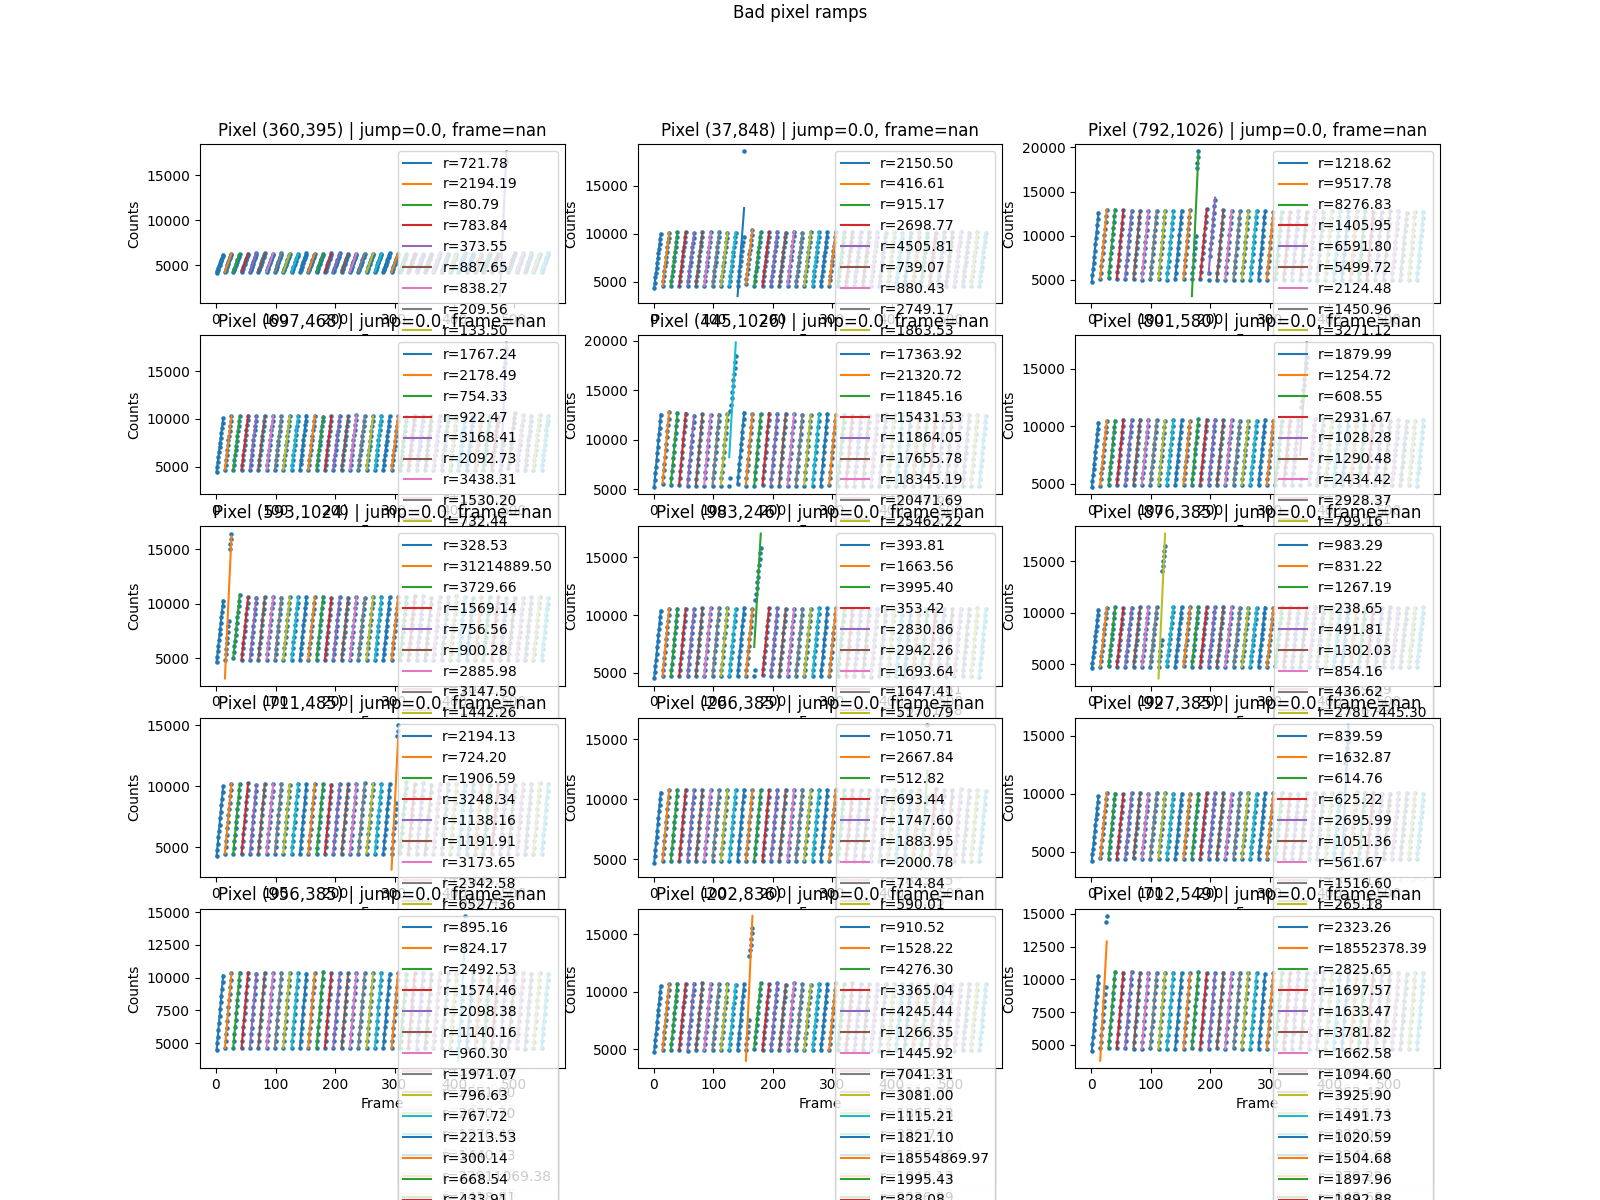

: Input data contains invalid values (NaNs or infs), which were automatically clipped. [astropy.stats.sigma_clipping]
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosm

INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 1: Found 25961 cosmic-ray pixels, Total: 25961 [lacosmic.core]
INFO: Iteration 1: Found 25248 cosmic-ray pixels, Total: 25248 [lacosmic.core]
INFO: Iteration 1: Found 26204 cosmic-ray pixels, Total: 26204 [lacosmic.core]
INFO: Iteration 1: Found 26277 cosmic-ray pixels, Total: 26277 [lacosmic.core]
INFO: Iteration 1: Found 25689 cosmic-ray pixels, Total: 25689 [lacosmic.core]
INFO: Iteration 1: Found 26069 cosmic-ray pixels, Total: 26069 [lacosmic.core]
INFO: Iteration 1: Found 23785 cosmic-ray pixels, Total: 23785 [lacosmic.core]
INFO: Iteration 1: Found 22433 cosmic-ray pixels, Total: 22433 [lacosmic.core]
INFO: Iteration 1: Found 26268 cosmic-ray pixels, Total: 26268 [lacosmic.core]
INFO: Iteration 1: Found 24159 cosmic-ray pixels, Total: 24159 [lacosmic.core]
INFO: Iteration 1: Found 26308 cosmic-ray pixels, Total: 26308 [lacosmic.core]
INFO: Iteration 1: Found 24115 cosmic-ray pixels, Total: 241

INFO: Iteration 4: Found 7 cosmic-ray pixels, Total: 25206 [lacosmic.core]
INFO: Iteration 4: Found 22 cosmic-ray pixels, Total: 27383 [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 27312 [lacosmic.core]
INFO: Iteration 4: Found 17 cosmic-ray pixels, Total: 27164 [lacosmic.core]
INFO: Iteration 4: Found 8 cosmic-ray pixels, Total: 24696 [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 16343 [lacosmic.core]
INFO: Iteration 4: Found 13 cosmic-ray pixels, Total: 27669 [lacosmic.core]
INFO: Iteration 4: Found 17 cosmic-ray pixels, Total: 25590 [lacosmic.core]
INFO: Iteration 4: Found 1 cosmic-ray pixels, Total: 16397 [lacosmic.core]
INFO: Iteration 4: Found 1 cosmic-ray pixels, Total: 18740 [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 14 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray 

INFO:     Found 293 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 421 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 382 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 373 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 24812 [lacosmic.core]
INFO:     Found 410 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 1 cosmic-ray pixels, Total: 25002 [lacosmic.core]
INFO:     Found 238 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 397 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 16422 [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 18780 [lacosmic.core]
INFO:     Found 99 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 0 cosmic-ray pixels, Total: 24820 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO:     Found 3 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 45 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 96 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 14 cosmic-ray pixels, Total: 25996 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 24688 [lacosmic.core]
INFO: Iteration 4: Found 10 cosmic-ray pixels, Total: 26003 [lacosmic.core]
INFO: Iteration 4: Found 10 cosmic-ray pixels, Total: 27002 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO: Iteration 4: Found 23 cosmic-ray pixels, Total: 26447 [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 26971 [lacosmic.core]
INFO:     Found 4 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 25001 [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 26723 [lacosmic.core]
INFO:     Found 3 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 18 cosmic-ray pixels, Total: 26217 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 23249 [lacosmic.core]
INFO: Iteration 1: Found 23853 cosmic-ray pixels, Total: 23853 [lacosmic.core]
INFO:     Found 359 5x5 masked regions while cleaning. [lacosmic.core]


INFO: Iteration 1: Found 24065 cosmic-ray pixels, Total: 24065 [lacosmic.core]
INFO:     Found 292 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 229 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24337 cosmic-ray pixels, Total: 24337 [lacosmic.core]
INFO:     Found 421 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 279 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 463 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24356 cosmic-ray pixels, Total: 24356 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO:     Found 259 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24961 cosmic-ray pixels, Total: 24961 [lacosmic.core]
INFO: Iteration 1: Found 26076 cosmic-ray pixels, Total: 26076 [lacosmic.core]
INFO: Iteration 1: Found 25930 cosmic-ray pixels, Total: 25930 [lacosmic.core]
INFO: Iteration 1: Found 16918 cosmic-ray pixels, Total: 16918 [lacosmic.core]
INFO: Iteration 1: Found 25888 cosmic-ray pixels, Total: 25888 [lacosmic.core]
INFO: Iteration 1: Found 26264 cosmic-ray pixels, Total: 26264 [lacosmic.core]
INFO: Iteration 1: Found 18197 cosmic-ray pixels, Total: 18197 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 1: Found 22357 cosmic-ray pixels, Total: 22357 [lacosmic.core]
INFO: Iteration 1: Found 24405 cosmic-ray pixels, Total: 24405 [lacosmic.core]
INFO: Iteration 1: Found 25035 cosmic-ray pixels, Total: 25035 [lacosmic.core]
INFO: Iteration 1: Found 24089 cosmic-ray pixels, Total: 24089 [laco

INFO:     Found 270 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 8 cosmic-ray pixels, Total: 23111 [lacosmic.core]
INFO:     Found 396 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 255 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 10 cosmic-ray pixels, Total: 25083 [lacosmic.core]
INFO:     Found 382 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 24776 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 26840 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 26082 [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 25731 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 27089 [lacosmic.core]
INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 26843 [lacosmic.core]
INFO: Iteration 4: Found 22 cosmic-ray pix

INFO: Iteration 4: Found 16 cosmic-ray pixels, Total: 25902 [lacosmic.core]
INFO: Iteration 4: Found 15 cosmic-ray pixels, Total: 27044 [lacosmic.core]
INFO: Iteration 4: Found 13 cosmic-ray pixels, Total: 27264 [lacosmic.core]
INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 25279 [lacosmic.core]
INFO: Iteration 4: Found 15 cosmic-ray pixels, Total: 27292 [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 24977 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 16865 [lacosmic.core]


INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 25358 [lacosmic.core]
INFO:     Found 399 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 3 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 24522 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 19507 [lacosmic.core]
INFO:     Found 3 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 68 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 24467 [lacosmic.core]
INFO:     Found 71 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 219 5x5 masked regions while cleaning. [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO:     Found 286 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 391 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 265 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 227 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 358 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 25933 [lacosmic.core]
INFO:     Found 345 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 24 cosmic-ray pixels, Total: 26853 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 23035 [lacosmic.core]
INFO: Iteration 4: Found 10 cosmic-ray pixels, Total: 26776 [lacosmic.core]
INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 27362 [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 26365 [lacosmic.core]
INFO: Iteration 1: Found 24275 cosmic-ray pixels, Total: 24275 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 4: Found 20 cosmic-ray pixels, Total: 27257 [lacosmic.core]
INFO: Iteration 1: Found 24508 cosmic-ray pixels, Total: 24508 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 4: Found 1 cosmic-ray pixels, Total: 24209 [lacosmic.core]
INFO:     Found 2 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24389 cosmic-ray pixels, Total: 24389 [lacosmic.core]
INFO: Iteration 1: Found 25252 cosmic-ray pixels, Total: 25252 [lacosmic.core]
INFO: Iteration 1: Found 26217 cosmic-ray pixels, Total: 26217 [lacosmic.core]


INFO: Iteration 1: Found 26406 cosmic-ray pixels, Total: 26406 [lacosmic.core]
INFO:     Found 78 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 26310 cosmic-ray pixels, Total: 26310 [lacosmic.core]
INFO:     Found 274 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 398 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25379 cosmic-ray pixels, Total: 25379 [lacosmic.core]
INFO:     Found 255 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 26070 cosmic-ray pixels, Total: 26070 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO:     Found 389 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 18612 cosmic-ray pixels, Total: 18612 [lacosmic.core]
INFO: Iteration 1: Found 16188 cosmic-ray pixels, Total: 16188 [lacosmic.core]
INFO: Iteration 1: Found 21809 cosmic-ray pixels, Total: 21809 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO:     Found 3 5x5 masked regions while cleaning. [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO:     Found 161 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24386 cosmic-ray pixels, Total: 24386 [lacosmic.core]
INFO:     Found 56 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 259 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24650 cosmic-ray pixels, Total: 24650 [lacosmic.core]
INFO: Iteration 1: Found 25828 cosmic-ray pixels, Total: 25828 [lacosmic.core]
INFO: Iteration 1: Found 23809 cosmic-ray pixels, Total: 23809 [lacosmic.core]
INFO: Iteration 1: Found 26199 cosmic-ray pixels, Total: 26199 [lacosmic.core]
INFO: Iteration 1: Found 26095 cosmic-ray pixels, Total: 26095 [lacosmic.core]
INFO: Iteration 1: Found 26211 cosmic-ray pixels, Total: 26211 [lacosmic.core]
INFO:     Found 174 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25074 cosmic-ray pixels, Total: 25074 [lacosmic.core]
INFO: Iteration 1: Found 25096 cosmic-ray pixels, Total: 25096 [lacosmic.core]
INFO: 

INFO:     Found 265 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 5 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 17 cosmic-ray pixels, Total: 27517 [lacosmic.core]
INFO: Iteration 4: Found 7 cosmic-ray pixels, Total: 22754 [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 25104 [lacosmic.core]
INFO:     Found 242 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 25325 [lacosmic.core]
INFO: Iteration 4: Found 1 cosmic-ray pixels, Total: 16792 [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 26841 [lacosmic.core]


INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 18878 [lacosmic.core]
INFO: Iteration 4: Found 17 cosmic-ray pixels, Total: 27260 [lacosmic.core]
INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 26968 [lacosmic.core]
INFO:     Found 264 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 14 cosmic-ray pixels, Total: 25896 [lacosmic.core]
INFO:     Found 370 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 18 cosmic-ray pixels, Total: 27298 [lacosmic.core]
INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 27070 [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 25209 [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 25427 [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 25289 [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 25098 [lacosmic.core]
INFO: Iteration 4: Found 7 cosmic-ray pixels, Total: 16502 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 24540 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 19117 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 25955 [lacosmic.core]
INFO: Iteration 4: Found 17 cosmic-ray pixels, Total: 26968 [lacosmic.core]
INFO:     Found 96 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 98 5x5 masked regions while cleaning. [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 24483 [lacosmic.core]
INFO:     Found 348 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 362 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 8 cosmic-ray pixels, Total: 26914 [lacosmic.core]
INFO:     Found 236 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 253 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 26341 [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 27454 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO:     Found 421 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24604 cosmic-ray pixels, Total: 24604 [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 23297 [lacosmic.core]
INFO: Iteration 1: Found 24353 cosmic-ray pixels, Total: 24353 [lacosmic.core]
INFO: Iteration 1: Found 25351 cosmic-ray pixels, Total: 25351 [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 24082 [lacosmic.core]
INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 26156 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO:     Found 3 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 91 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 25012 [lacosmic.core]
INFO: Iteration 1: Found 25728 cosmic-ray pixels, Total: 25728 [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 26882 [lacosmic.core]
INFO:     Found 372 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25855 cosmic-ray pixels, Total: 25855 [lacosmic.core]
INFO: Iteration 1: Found 26492 cosmic-ray pixels, Total: 26492 [lacosmic.core]
INFO: Iteration 1: Found 25824 cosmic-ray pixels, Total: 25824 [lacosmic.core]


INFO: Iteration 1: Found 25296 cosmic-ray pixels, Total: 25296 [lacosmic.core]
INFO:     Found 242 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 367 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 2 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 18462 cosmic-ray pixels, Total: 18462 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO:     Found 3 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 50 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 1: Found 22278 cosmic-ray pixels, Total: 22278 [lacosmic.core]
INFO:     Found 327 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 266 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24604 cosmic-ray pixels, Total: 24604 [lacosmic.core]
INFO: Iteration 1: Found 24295 cosmic-ray pixels, Total: 24295 [lacosmic.core]
INFO: Iteration 1: Found 23839 cosmic-ray pixels, Total: 23839 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO:     Found 160 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 16449 cosmic-ray pixels, Total: 16449 [lacosmic.core]
INFO:     Found 261 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25060 cosmic-ray pixels, Total: 25060 [lacosmic.core]
INFO:     Found 184 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24759 cosmic-ray pixels, Total: 24759 [lacosmic.core]
INFO: Iteration 1: Found 26091 cosmic-ray pixels, Total: 26091 [lacosmic.core]
INFO: Iteration 1: Found 25923 cosmic-ray pixels, Total: 25923 [lacosmic.core]
INFO: Iteration 1: Found 26413 cosmic-ray pixels, Total: 26413 [lacosmic.core]
INFO: Iteration 1: Found 25702 cosmic-ray pixels, Total: 25702 [lacosmic.core]
INFO: Iteration 1: Found 18778 cosmic-ray pixels, Total: 18778 [lacosmic.core]
INFO: Iteration 1: Found 16313 cosmic-ray pixels, Total: 16313 [lacosmic.core]
INFO: Iteration 1: Found 26204 cosmic-ray pixels, Total: 26204 [lacosmic.cor

INFO:     Found 364 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 254 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 16714 [lacosmic.core]
INFO:     Found 6 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 82 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 35 cosmic-ray pixels, Total: 25056 [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 22918 [lacosmic.core]
INFO:     Found 346 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 14 cosmic-ray pixels, Total: 27448 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 25075 [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 24562 [lacosmic.core]
INFO: Iteration 4: Found 10 cosmic-ray pixels, Total: 19497 [lacosmic.core]
INFO:     Found 425 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 8 cosmic-ray pixels, To

INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 23005 [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 24749 [lacosmic.core]
INFO: Iteration 4: Found 14 cosmic-ray pixels, Total: 26732 [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 4: Found 14 cosmic-ray pixels, Total: 27461 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)
WARNING

INFO:     Found 261 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 16668 [lacosmic.core]
INFO:     Found 3 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 1 cosmic-ray pixels, Total: 19448 [lacosmic.core]


: Input data contains invalid values (NaNs or infs), which were automatically clipped. [astropy.stats.sigma_clipping]


INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 27128 [lacosmic.core]
INFO:     Found 287 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 105 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 25334 [lacosmic.core]
INFO: Iteration 4: Found 15 cosmic-ray pixels, Total: 27454 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 24994 [lacosmic.core]
INFO:     Found 252 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 25109 [lacosmic.core]
INFO: Iteration 4: Found 15 cosmic-ray pixels, Total: 26245 [lacosmic.core]
INFO: Iteration 1: Found 25502 cosmic-ray pixels, Total: 25502 [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 27115 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO: Iteration 4: Found 18 cosmic-ray pixels, Total: 26061 [lacosmic.core]
INFO: Iteration 1: Found 26291 cosmic-ray pixels, Total: 26291 [lacosmic.core]
INFO: Iteration 1: Found 24747 cosmic-ray pixels, Total: 24747 [lacosmic.core]
INFO:     Found 368 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 4: Found 27 cosmic-ray pixels, Total: 27378 [lacosmic.core]
INFO: Iteration 1: Found 26073 cosmic-ray pixels, Total: 26073 [lacosmic.core]
INFO: Iteration 4: Found 7 cosmic-ray pixels, Total: 26943 [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 24814 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO:     Found 373 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 7 cosmic-ray pixels, Total: 25773 [lacosmic.core]
INFO: Iteration 4: Found 8 cosmic-ray pixels, Total: 23180 [lacosmic.core]
INFO: Iteration 1: Found 26421 cosmic-ray pixels, Total: 26421 [lacosmic.core]
INFO: Iteration 1: Found 25587 cosmic-ray pixels, Total: 25587 [lacosmic.core]
INFO:     Found 260 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25261 cosmic-ray pixels, Total: 25261 [lacosmic.core]
INFO:     Found 367 5x5 masked regions while cleaning. [lacosmic.core]


INFO: Iteration 1: Found 18756 cosmic-ray pixels, Total: 18756 [lacosmic.core]
INFO:     Found 258 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 4 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 34 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 16465 cosmic-ray pixels, Total: 16465 [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 25058 [lacosmic.core]
INFO:     Found 189 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 86 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 22589 cosmic-ray pixels, Total: 22589 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO: Iteration 1: Found 23859 cosmic-ray pixels, Total: 23859 [lacosmic.core]
INFO:     Found 348 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24424 cosmic-ray pixels, Total: 24424 [lacosmic.core]
INFO: Iteration 1: Found 24759 cosmic-ray pixels, Total: 24759 [lacosmic.core]
INFO: Iteration 1: Found 24355 cosmic-ray pixels, Total: 24355 [lacosmic.core]
INFO: Iteration 1: Found 25224 cosmic-ray pixels, Total: 25224 [lacosmic.core]
INFO:     Found 275 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 26669 cosmic-ray pixels, Total: 26669 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 1: Found 26139 cosmic-ray pixels, Total: 26139 [lacosmic.core]
INFO:     Found 273 5x5 masked regions while cleaning. [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO:     Found 154 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 26070 cosmic-ray pixels, Total: 26070 [lacosmic.core]
INFO: Iteration 1: Found 26039 cosmic-ray pixels, Total: 26039 [lacosmic.core]
INFO: Iteration 1: Found 18847 cosmic-ray pixels, Total: 18847 [lacosmic.core]
INFO: Iteration 1: Found 16310 cosmic-ray pixels, Total: 16310 [lacosmic.core]
INFO: Iteration 1: Found 25347 cosmic-ray pixels, Total: 25347 [lacosmic.core]
INFO: Iteration 1: Found 22277 cosmic-ray pixels, Total: 22277 [lacosmic.core]


INFO: Iteration 1: Found 23613 cosmic-ray pixels, Total: 23613 [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24571 cosmic-ray pixels, Total: 24571 [lacosmic.core]
INFO: Iteration 1: Found 24500 cosmic-ray pixels, Total: 24500 [lacosmic.core]
INFO:     Found 61 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 178 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 234 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 260 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24191 cosmic-ray pixels, Total: 24191 [lacosmic.core]
INFO: Iteration 2: Found 931 cosmic-ray pixels, Total: 26433 [lacosmic.core]
INFO: Iteration 1: Found 26171 cosmic-ray pixels, Total: 26171 [lacosmic.core]
INFO:     Found 173 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 994 cosmic-ray pixels, Total: 27285 [lacosmic.core]
INFO: Iteration 2: Found 651

INFO: Iteration 3: Found 84 cosmic-ray pixels, Total: 26904 [lacosmic.core]
INFO: Iteration 4: Found 14 cosmic-ray pixels, Total: 27301 [lacosmic.core]
INFO: Iteration 3: Found 38 cosmic-ray pixels, Total: 24847 [lacosmic.core]
INFO: Iteration 3: Found 54 cosmic-ray pixels, Total: 23372 [lacosmic.core]
INFO:     Found 12 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 16781 [lacosmic.core]
INFO: Iteration 4: Found 10 cosmic-ray pixels, Total: 23347 [lacosmic.core]
INFO: Iteration 3: Found 74 cosmic-ray pixels, Total: 25588 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 24583 [lacosmic.core]
INFO: Iteration 4: Found 14 cosmic-ray pixels, Total: 19400 [lacosmic.core]
INFO: Iteration 3: Found 46 cosmic-ray pixels, Total: 25275 [lacosmic.core]
INFO:     Found 262 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 259 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 105 5x5 masked

INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 25054 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 26217 [lacosmic.core]
INFO: Iteration 3: Found 46 cosmic-ray pixels, Total: 25523 [lacosmic.core]
INFO:     Found 360 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 28 cosmic-ray pixels, Total: 27774 [lacosmic.core]
INFO: Iteration 4: Found 10 cosmic-ray pixels, Total: 27023 [lacosmic.core]
INFO:     Found 353 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 22846 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO: Iteration 4: Found 7 cosmic-ray pixels, Total: 26936 [lacosmic.core]
INFO: Iteration 4: Found 8 cosmic-ray pixels, Total: 27006 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO:     Found 362 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 240 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 24395 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 25200 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 25385 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 1: Found 25277 cosmic-ray pixels, Total: 25277 [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 26106 [lacosmic.core]
INFO:     Found 6 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 16745 [lacosmic.core]
INFO:     Found 122 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 24859 [lacosmic.core]
INFO:     Found 268 5x5 masked regions while cleaning. [lacosmic.core]


INFO: Iteration 1: Found 26085 cosmic-ray pixels, Total: 26085 [lacosmic.core]
INFO:     Found 355 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 327 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 26129 cosmic-ray pixels, Total: 26129 [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 19238 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 27136 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 25748 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 1: Found 25723 cosmic-ray pixels, Total: 25723 [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 26492 [lacosmic.core]
INFO:     Found 3 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 254 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 26267 cosmic-ray pixels, Total: 26267 [lacosmic.core]
INFO: Iteration 4: Found 20 cosmic-ray pixels, Total: 26334 [lacosmic.core]
INFO: Iteration 4: Found 18 cosmic-ray pixels, Total: 27056 [lacosmic.core]
INFO: Iteration 1: Found 25064 cosmic-ray pixels, Total: 25064 [lacosmic.core]


INFO: Iteration 4: Found 0 cosmic-ray pixels, Total: 24847 [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 23375 [lacosmic.core]
INFO:     Found 48 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 18418 cosmic-ray pixels, Total: 18418 [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 26909 [lacosmic.core]
INFO:     Found 155 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 15728 cosmic-ray pixels, Total: 15728 [lacosmic.core]
INFO: Iteration 1: Found 22469 cosmic-ray pixels, Total: 22469 [lacosmic.core]
INFO:     Found 261 5x5 masked regions while cleaning. [lacosmic.core]


INFO:     Found 265 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 23861 cosmic-ray pixels, Total: 23861 [lacosmic.core]
INFO:     Found 219 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 10 cosmic-ray pixels, Total: 25285 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 25600 [lacosmic.core]
INFO:     Found 374 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24458 cosmic-ray pixels, Total: 24458 [lacosmic.core]
INFO:     Found 253 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 124 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO: Iteration 1: Found 24983 cosmic-ray pixels, Total: 24983 [lacosmic.core]
INFO: Iteration 1: Found 25244 cosmic-ray pixels, Total: 25244 [lacosmic.core]
INFO: Iteration 1: Found 24372 cosmic-ray pixels, Total: 24372 [lacosmic.core]
INFO: Iteration 1: Found 25720 cosmic-ray pixels, Total: 25720 [lacosmic.core]
INFO:     Found 119 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 26016 cosmic-ray pixels, Total: 26016 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 25527 [lacosmic.core]
INFO: Iteration 1: Found 25457 cosmic-ray pixels, Total: 25457 [lacosmic.core]
INFO: Iteration 1: Found 26287 cosmic-ray pixels, Total: 26287 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO:     Found 357 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25917 cosmic-ray pixels, Total: 25917 [lacosmic.core]
INFO: Iteration 1: Found 18691 cosmic-ray pixels, Total: 18691 [lacosmic.core]
INFO: Iteration 1: Found 16671 cosmic-ray pixels, Total: 16671 [lacosmic.core]
INFO: Iteration 1: Found 22970 cosmic-ray pixels, Total: 22970 [lacosmic.core]


INFO: Iteration 1: Found 24139 cosmic-ray pixels, Total: 24139 [lacosmic.core]
INFO: Iteration 1: Found 24422 cosmic-ray pixels, Total: 24422 [lacosmic.core]
INFO: Iteration 2: Found 864 cosmic-ray pixels, Total: 26141 [lacosmic.core]
INFO: Iteration 1: Found 23912 cosmic-ray pixels, Total: 23912 [lacosmic.core]
INFO: Iteration 1: Found 24870 cosmic-ray pixels, Total: 24870 [lacosmic.core]
INFO:     Found 56 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 223 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25450 cosmic-ray pixels, Total: 25450 [lacosmic.core]
INFO:     Found 136 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 26076 cosmic-ray pixels, Total: 26076 [lacosmic.core]


INFO:     Found 263 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 177 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 885 cosmic-ray pixels, Total: 26970 [lacosmic.core]
INFO: Iteration 2: Found 870 cosmic-ray pixels, Total: 26999 [lacosmic.core]
INFO: Iteration 1: Found 25903 cosmic-ray pixels, Total: 25903 [lacosmic.core]
INFO: Iteration 1: Found 26124 cosmic-ray pixels, Total: 26124 [lacosmic.core]
INFO: Iteration 2: Found 887 cosmic-ray pixels, Total: 26610 [lacosmic.core]
INFO:     Found 5 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 26071 cosmic-ray pixels, Total: 26071 [lacosmic.core]
INFO: Iteration 1: Found 24965 cosmic-ray pixels, Total: 24965 [lacosmic.core]
INFO: Iteration 2: Found 482 cosmic-ray pixels, Total: 18900 [lacosmic.core]
INFO: Iteration 2: Found 427 cosmic-ray pixels, Total: 16155 [lacosmic.core]
INFO: Iteration 2: Found 862 cosmic-ray pixels, Total: 27129 [lacosmic.core]
INFO: Itera

INFO: Iteration 3: Found 29 cosmic-ray pixels, Total: 18822 [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 25970 [lacosmic.core]
INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 23234 [lacosmic.core]
INFO: Iteration 4: Found 13 cosmic-ray pixels, Total: 27237 [lacosmic.core]
INFO:     Found 5 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 145 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 18 cosmic-ray pixels, Total: 24680 [lacosmic.core]
INFO: Iteration 3: Found 54 cosmic-ray pixels, Total: 24722 [lacosmic.core]
INFO:     Found 264 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 121 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 27 cosmic-ray pixels, Total: 22615 [lacosmic.core]
INFO:     Found 270 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 17129 [lacosmic.core]
INFO: Iteration 4: Found 14 cosmic-ray pi

/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO:     Found 334 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 222 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 13 cosmic-ray pixels, Total: 26117 [lacosmic.core]
INFO:     Found 344 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 23 cosmic-ray pixels, Total: 25037 [lacosmic.core]
INFO: Iteration 3: Found 21 cosmic-ray pixels, Total: 25028 [lacosmic.core]
INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 26733 [lacosmic.core]
INFO: Iteration 4: Found 22 cosmic-ray pixels, Total: 26326 [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 25095 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 4: Found 1 cosmic-ray pixels, Total: 25783 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 4: Found 8 cosmic-ray pixels, Total: 26897 [lacosmic.core]
INFO: Iteration 4: Found 49 cosmic-ray pixels, Total: 23969 [lacosmic.core]
INFO: Iteration 4: Found 17 cosmic-ray pixels, Total: 27215 [lacosmic.core]
INFO: Iteration 4: Found 1 cosmic-ray pixels, Total: 25082 [lacosmic.core]
INFO: Iteration 4: Found 62 cosmic-ray pixels, Total: 25177 [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 24666 [lacosmic.core]
INFO: Iteration 3: Found 79 cosmic-ray pixels, Total: 26429 [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 26748 [lacosmic.core]
INFO: Iteration 4: Found 17 cosmic-ray pixels, Total: 25753 [lacosmic.core]
INFO:     Found 4 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25918 cosmi

INFO:     Found 227 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25977 cosmic-ray pixels, Total: 25977 [lacosmic.core]
INFO:     Found 118 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 27057 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 26443 [lacosmic.core]
INFO: Iteration 1: Found 26138 cosmic-ray pixels, Total: 26138 [lacosmic.core]
INFO:     Found 349 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 364 5x5 masked regions while cleaning. [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 1 cosmic-ray pixels, Total: 16563 [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 26822 [lacosmic.core]
INFO: Iteration 1: Found 26240 cosmic-ray pixels, Total: 26240 [lacosmic.core]
INFO: Iteration 1: Found 25283 cosmic-ray pixels, Total: 25283 [lacosmic.core]
INFO:     Found 265 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 8 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 4: Found 8 cosmic-ray pixels, Total: 25762 [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 18825 [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 26936 [lacosmic.core]
INFO:     Found 72 5x5 masked regions while cleaning. [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 1: Found 18514 cosmic-ray pixels, Total: 18514 [lacosmic.core]
INFO: Iteration 4: Found 14 cosmic-ray pixels, Total: 27007 [lacosmic.core]
INFO:     Found 188 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 147 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 16570 cosmic-ray pixels, Total: 16570 [lacosmic.core]
INFO:     Found 237 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 5 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 24731 [lacosmic.core]
INFO: Iteration 1: Found 22444 cosmic-ray pixels, Total: 22444 [lacosmic.core]


INFO: Iteration 4: Found 1 cosmic-ray pixels, Total: 22616 [lacosmic.core]
INFO:     Found 253 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 23768 cosmic-ray pixels, Total: 23768 [lacosmic.core]
INFO:     Found 159 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24510 cosmic-ray pixels, Total: 24510 [lacosmic.core]
INFO:     Found 273 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24377 cosmic-ray pixels, Total: 24377 [lacosmic.core]
INFO: Iteration 1: Found 24237 cosmic-ray pixels, Total: 24237 [lacosmic.core]
INFO:     Found 235 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25100 cosmic-ray pixels, Total: 25100 [lacosmic.core]
INFO:     Found 344 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 25516 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO:     Found 337 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25744 cosmic-ray pixels, Total: 25744 [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 25042 [lacosmic.core]
INFO: Iteration 4: Found 0 cosmic-ray pixels, Total: 25028 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 1: Found 26156 cosmic-ray pixels, Total: 26156 [lacosmic.core]
INFO: Iteration 1: Found 25989 cosmic-ray pixels, Total: 25989 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 1: Found 18907 cosmic-ray pixels, Total: 18907 [lacosmic.core]
INFO: Iteration 1: Found 25858 cosmic-ray pixels, Total: 25858 [lacosmic.core]
INFO: Iteration 1: Found 24857 cosmic-ray pixels, Total: 24857 [lacosmic.core]
INFO:     Found 4 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 22246 cosmic-ray pixels, Total: 22246 [lacosmic.core]
INFO: Iteration 1: Found 23824 cosmic-ray pixels, Total: 23824 [lacosmic.core]
INFO: Iteration 1: Found 16242 cosmic-ray pixels, Total: 16242 [lacosmic.core]
INFO: Iteration 1: Found 24601 cosmic-ray pixels, Total: 24601 [lacosmic.core]
INFO: Iteration 2: Found 967 cosmic-ray pixels, Total: 26885 [lacosmic.core]
INFO: Iteration 1: Found 24761 cosmic-ray pixels, Total: 24761 [lacosmic.core]
INFO:     Found 62 5x5 masked regions while cleaning. [lacosmic.core]


INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 26438 [lacosmic.core]
INFO: Iteration 1: Found 24467 cosmic-ray pixels, Total: 24467 [lacosmic.core]
INFO: Iteration 1: Found 25224 cosmic-ray pixels, Total: 25224 [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 895 cosmic-ray pixels, Total: 26872 [lacosmic.core]
INFO: Iteration 2: Found 901 cosmic-ray pixels, Total: 27039 [lacosmic.core]
INFO:     Found 198 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25428 cosmic-ray pixels, Total: 25428 [lacosmic.core]
INFO:     Found 239 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 26157 cosmic-ray pixels, Total: 26157 [lacosmic.core]
INFO: Iteration 1: Found 26211 cosmic-ray pixels, Total: 26211 [lacosmic.core]
INFO: Iteration 2: Found 846 cosmic-ray pixels, Total: 27086 [lacosmic.core]
INFO: Iteration 2: Found 750 cosmic-ray pixels, Total: 26033 [lacosmic.core]
INFO:     F

INFO:     Found 184 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 231 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 22704 cosmic-ray pixels, Total: 22704 [lacosmic.core]
INFO: Iteration 2: Found 694 cosmic-ray pixels, Total: 24462 [lacosmic.core]
INFO: Iteration 2: Found 560 cosmic-ray pixels, Total: 23004 [lacosmic.core]
INFO: Iteration 1: Found 16659 cosmic-ray pixels, Total: 16659 [lacosmic.core]
INFO:     Found 203 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 317 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 642 cosmic-ray pixels, Total: 25152 [lacosmic.core]
INFO: Iteration 2: Found 694 cosmic-ray pixels, Total: 25071 [lacosmic.core]
INFO: Iteration 2: Found 731 cosmic-ray pixels, Total: 24968 [lacosmic.core]
INFO: Iteration 1: Found 24282 cosmic-ray pixels, Total: 24282 [lacosmic.core]
INFO: Iteration 1: Found 24691 cosmic-ray pixels, Total: 24691 [lacosmic.core]
INFO: Iteration

INFO:     Found 237 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 85 cosmic-ray pixels, Total: 26988 [lacosmic.core]
INFO:     Found 149 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 4 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 40 cosmic-ray pixels, Total: 17165 [lacosmic.core]
INFO:     Found 340 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 323 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 276 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 74 cosmic-ray pixels, Total: 23451 [lacosmic.core]
INFO:     Found 149 5x5 masked regions while cleaning. [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO: Iteration 4: Found 8 cosmic-ray pixels, Total: 24512 [lacosmic.core]
INFO: Iteration 3: Found 80 cosmic-ray pixels, Total: 25844 [lacosmic.core]
INFO: Iteration 4: Found 1 cosmic-ray pixels, Total: 25193 [lacosmic.core]
INFO:     Found 227 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 351 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 25008 [lacosmic.core]
INFO: Iteration 4: Found 1 cosmic-ray pixels, Total: 25100 [lacosmic.core]
INFO:     Found 264 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 23053 [lacosmic.core]
INFO:     Found 314 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 72 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 28 cosmic-ray pixels, Total: 25391 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 4: Found 19 cosmic-ray pixels, Total: 26000 [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 19399 [lacosmic.core]
INFO:     Found 346 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 67 cosmic-ray pixels, Total: 25130 [lacosmic.core]
INFO: Iteration 3: Found 41 cosmic-ray pixels, Total: 25324 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 16643 [lacosmic.core]
INFO: Iteration 4: Found 21 cosmic-ray pixels, Total: 26880 [lacosmic.core]
INFO: Iteration 3: Found 39 cosmic-ray pixels, Total: 25473 [lacosmic.core]
INFO: Iteration 4: Found 1 cosmic-ray pixels, Total: 22856 [lacosmic.core]
INFO: Iteration 4: Found 14 cosmic-ray pixels, Total: 27151 [lacosmic.core]
INFO:     Found 250 5x5 masked regions while cleaning. [lacosmic.core]


INFO: Iteration 4: Found 16 cosmic-ray pixels, Total: 26918 [lacosmic.core]
INFO: Iteration 4: Found 1 cosmic-ray pixels, Total: 24475 [lacosmic.core]
INFO:     Found 5 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 118 cosmic-ray pixels, Total: 26314 [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 25432 [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 25591 [lacosmic.core]
INFO: Iteration 1: Found 26081 cosmic-ray pixels, Total: 26081 [lacosmic.core]


INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 25190 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 25696 [lacosmic.core]
INFO: Iteration 4: Found 8 cosmic-ray pixels, Total: 26192 [lacosmic.core]
INFO:     Found 142 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25986 cosmic-ray pixels, Total: 25986 [lacosmic.core]
INFO: Iteration 1: Found 26149 cosmic-ray pixels, Total: 26149 [lacosmic.core]
INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 26695 [lacosmic.core]
INFO:     Found 280 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 7 cosmic-ray pixels, Total: 19307 [lacosmic.core]
INFO: Iteration 4: Found 20 cosmic-ray pixels, Total: 26485 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO: Iteration 1: Found 25064 cosmic-ray pixels, Total: 25064 [lacosmic.core]
INFO:     Found 339 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 2 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 19 cosmic-ray pixels, Total: 27172 [lacosmic.core]
INFO:     Found 2 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 8 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 16121 cosmic-ray pixels, Total: 16121 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 17169 [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 18878 cosmic-ray pixels, Total: 18878 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 27210 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO:     Found 162 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 125 cosmic-ray pixels, Total: 26985 [lacosmic.core]
INFO:     Found 4 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 13 cosmic-ray pixels, Total: 27001 [lacosmic.core]
INFO:     Found 238 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 269 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 22202 cosmic-ray pixels, Total: 22202 [lacosmic.core]
INFO: Iteration 4: Found 15 cosmic-ray pixels, Total: 23466 [lacosmic.core]
INFO:     Found 233 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 154 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 342 5x5 masked regions while cleaning. [lacosmic.core]


INFO:     Found 190 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 23874 cosmic-ray pixels, Total: 23874 [lacosmic.core]
INFO: Iteration 4: Found 23 cosmic-ray pixels, Total: 25867 [lacosmic.core]
INFO: Iteration 1: Found 24559 cosmic-ray pixels, Total: 24559 [lacosmic.core]
INFO:     Found 264 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24489 cosmic-ray pixels, Total: 24489 [lacosmic.core]


INFO: Iteration 1: Found 24399 cosmic-ray pixels, Total: 24399 [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 25394 [lacosmic.core]
INFO: Iteration 1: Found 25460 cosmic-ray pixels, Total: 25460 [lacosmic.core]
INFO: Iteration 1: Found 25817 cosmic-ray pixels, Total: 25817 [lacosmic.core]
INFO:     Found 318 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 87 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 351 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 10 cosmic-ray pixels, Total: 25334 [lacosmic.core]
INFO: Iteration 1: Found 26279 cosmic-ray pixels, Total: 26279 [lacosmic.core]
INFO: Iteration 4: Found 16 cosmic-ray pixels, Total: 25146 [lacosmic.core]
INFO: Iteration 1: Found 26285 cosmic-ray pixels, Total: 26285 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 25476 [lacosmic.core]
INFO: Iteration 1: Found 25988 cosmic-ray pixels, Total: 25988 [lacosmic.core]
INFO: Iteration 1: Found 25279 cosmic-ray pixels, Total: 25279 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO:     Found 259 5x5 masked regions while cleaning. [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO:     Found 2 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 78 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 18566 cosmic-ray pixels, Total: 18566 [lacosmic.core]
INFO: Iteration 1: Found 16312 cosmic-ray pixels, Total: 16312 [lacosmic.core]
INFO:     Found 159 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 197 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 24 cosmic-ray pixels, Total: 26338 [lacosmic.core]
INFO: Iteration 2: Found 1075 cosmic-ray pixels, Total: 27156 [lacosmic.core]
INFO: Iteration 1: Found 22143 cosmic-ray pixels, Total: 22143 [lacosmic.core]
INFO: Iteration 1: Found 23854 cosmic-ray pixels, Total: 23854 [lacosmic.core]
INFO: Iteration 1: Found 24261 cosmic-ray pixels, Total: 24261 [lacosmic.core]


INFO: Iteration 1: Found 24605 cosmic-ray pixels, Total: 24605 [lacosmic.core]
INFO: Iteration 2: Found 869 cosmic-ray pixels, Total: 26855 [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 253 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24444 cosmic-ray pixels, Total: 24444 [lacosmic.core]
INFO:     Found 151 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25029 cosmic-ray pixels, Total: 25029 [lacosmic.core]
INFO: Iteration 2: Found 404 cosmic-ray pixels, Total: 16525 [lacosmic.core]
INFO: Iteration 2: Found 787 cosmic-ray pixels, Total: 25851 [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 26145 cosmic-ray pixels, Total: 26145 [lacosmic.core]
INFO: Iteration 2: Found 886 cosmic-ray pixels, Total: 27035 [lacosmic.core]
INFO: Iteration 1: Found 26045 cosmic-ray pixels, Total: 26045 [lacosmic.core]
INFO: Iteration 2

INFO:     Found 338 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 16137 cosmic-ray pixels, Total: 16137 [lacosmic.core]
INFO: Iteration 1: Found 18729 cosmic-ray pixels, Total: 18729 [lacosmic.core]
INFO: Iteration 2: Found 621 cosmic-ray pixels, Total: 22823 [lacosmic.core]
INFO: Iteration 4: Found 19 cosmic-ray pixels, Total: 27004 [lacosmic.core]
INFO:     Found 274 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 187 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 65 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 583 cosmic-ray pixels, Total: 24457 [lacosmic.core]
INFO:     Found 289 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 722 cosmic-ray pixels, Total: 25281 [lacosmic.core]
INFO: Iteration 2: Found 622 cosmic-ray pixels, Total: 25111 [lacosmic.core]
INFO:     Found 219 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 626 cosm

INFO: Iteration 2: Found 754 cosmic-ray pixels, Total: 26033 [lacosmic.core]
INFO: Iteration 1: Found 24512 cosmic-ray pixels, Total: 24512 [lacosmic.core]
INFO: Iteration 2: Found 341 cosmic-ray pixels, Total: 16653 [lacosmic.core]
INFO: Iteration 2: Found 447 cosmic-ray pixels, Total: 19013 [lacosmic.core]
INFO: Iteration 1: Found 25283 cosmic-ray pixels, Total: 25283 [lacosmic.core]
INFO:     Found 6 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 120 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 583 cosmic-ray pixels, Total: 22726 [lacosmic.core]
INFO:     Found 235 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 679 cosmic-ray pixels, Total: 24533 [lacosmic.core]
INFO: Iteration 3: Found 25 cosmic-ray pixels, Total: 16550 [lacosmic.core]
INFO: Iteration 2: Found 664 cosmic-ray pixels, Total: 24925 [lacosmic.core]
INFO:     Found 259 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Fou

INFO: Iteration 3: Found 40 cosmic-ray pixels, Total: 16518 [lacosmic.core]
INFO: Iteration 3: Found 80 cosmic-ray pixels, Total: 27101 [lacosmic.core]
INFO:     Found 2 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 969 cosmic-ray pixels, Total: 27031 [lacosmic.core]
INFO: Iteration 3: Found 28 cosmic-ray pixels, Total: 19183 [lacosmic.core]
INFO: Iteration 3: Found 58 cosmic-ray pixels, Total: 26225 [lacosmic.core]


INFO: Iteration 3: Found 93 cosmic-ray pixels, Total: 27009 [lacosmic.core]
INFO:     Found 261 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 22 cosmic-ray pixels, Total: 27194 [lacosmic.core]
INFO:     Found 369 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 79 cosmic-ray pixels, Total: 27149 [lacosmic.core]
INFO:     Found 298 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 76 cosmic-ray pixels, Total: 26568 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO:     Found 265 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 24505 [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 22858 [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 25338 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 25145 [lacosmic.core]
INFO:     Found 108 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 25047 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO:     Found 258 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 16674 [lacosmic.core]


INFO: Iteration 3: Found 78 cosmic-ray pixels, Total: 25052 [lacosmic.core]
INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 26408 [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 26777 [lacosmic.core]
INFO: Iteration 2: Found 763 cosmic-ray pixels, Total: 26933 [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 19048 [lacosmic.core]
INFO:     Found 122 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 27265 [lacosmic.core]
INFO: Iteration 3: Found 38 cosmic-ray pixels, Total: 22930 [lacosmic.core]
INFO:     Found 329 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 77 cosmic-ray pixels, Total: 25389 [lacosmic.core]
INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 27228 [lacosmic.core]


INFO:     Found 294 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 26103 [lacosmic.core]
INFO:     Found 364 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 15 cosmic-ray pixels, Total: 27004 [lacosmic.core]
INFO: Iteration 3: Found 46 cosmic-ray pixels, Total: 24304 [lacosmic.core]
INFO: Iteration 1: Found 26053 cosmic-ray pixels, Total: 26053 [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 22760 [lacosmic.core]
INFO: Iteration 3: Found 78 cosmic-ray pixels, Total: 26167 [lacosmic.core]


INFO:     Found 8 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 24590 [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 24963 [lacosmic.core]
INFO:     Found 136 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 32 cosmic-ray pixels, Total: 25253 [lacosmic.core]
INFO:     Found 229 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 261 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25940 cosmic-ray pixels, Total: 25940 [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 16521 [lacosmic.core]
INFO: Iteration 4: Found 1 cosmic-ray pixels, Total: 25300 [lacosmic.core]
INFO:     Found 297 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 10 cosmic-ray pixels, Total: 25119 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO:     Found 244 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25269 cosmic-ray pixels, Total: 25269 [lacosmic.core]
INFO:     Found 335 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 19 cosmic-ray pixels, Total: 25958 [lacosmic.core]
INFO:     Found 192 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 1 cosmic-ray pixels, Total: 19184 [lacosmic.core]
INFO: Iteration 1: Found 18867 cosmic-ray pixels, Total: 18867 [lacosmic.core]
INFO: Iteration 4: Found 10 cosmic-ray pixels, Total: 27111 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO:     Found 2 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 16203 cosmic-ray pixels, Total: 16203 [lacosmic.core]
INFO: Iteration 3: Found 89 cosmic-ray pixels, Total: 27120 [lacosmic.core]
INFO:     Found 244 5x5 masked regions while cleaning. [lacosmic.core]


INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 26236 [lacosmic.core]
INFO:     Found 170 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 27021 [lacosmic.core]
INFO:     Found 268 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 22596 cosmic-ray pixels, Total: 22596 [lacosmic.core]


INFO: Iteration 1: Found 24082 cosmic-ray pixels, Total: 24082 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 27161 [lacosmic.core]
INFO: Iteration 4: Found 13 cosmic-ray pixels, Total: 26581 [lacosmic.core]
INFO: Iteration 1: Found 24159 cosmic-ray pixels, Total: 24159 [lacosmic.core]
INFO: Iteration 1: Found 24647 cosmic-ray pixels, Total: 24647 [lacosmic.core]
INFO: Iteration 1: Found 24529 cosmic-ray pixels, Total: 24529 [lacosmic.core]
INFO: Iteration 1: Found 25424 cosmic-ray pixels, Total: 25424 [lacosmic.core]
INFO: Iteration 4: Found 8 cosmic-ray pixels, Total: 25060 [lacosmic.core]
INFO: Iteration 1: Found 26136 cosmic-ray pixels, Total: 26136 [lacosmic.core]
INFO:     Found 129 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25607 cosmic-ray pixels, Total: 25607 [lacosmic.core]
INFO:     Found 261 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 26270 cosmic-ray pixels, Total: 26270 [lacosmic.core]

INFO: Iteration 2: Found 759 cosmic-ray pixels, Total: 26812 [lacosmic.core]
INFO:     Found 124 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 18483 cosmic-ray pixels, Total: 18483 [lacosmic.core]
INFO: Iteration 1: Found 16627 cosmic-ray pixels, Total: 16627 [lacosmic.core]
INFO:     Found 372 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 24313 [lacosmic.core]
INFO:     Found 296 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 26178 [lacosmic.core]
INFO: Iteration 1: Found 22631 cosmic-ray pixels, Total: 22631 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO:     Found 162 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 23837 cosmic-ray pixels, Total: 23837 [lacosmic.core]
INFO: Iteration 1: Found 24556 cosmic-ray pixels, Total: 24556 [lacosmic.core]
INFO: Iteration 1: Found 24130 cosmic-ray pixels, Total: 24130 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 1: Found 24654 cosmic-ray pixels, Total: 24654 [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 40 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 244 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 262 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 696 cosmic-ray pixels, Total: 26636 [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 142 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels

INFO: Iteration 2: Found 688 cosmic-ray pixels, Total: 25957 [lacosmic.core]
INFO:     Found 256 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25371 cosmic-ray pixels, Total: 25371 [lacosmic.core]
INFO:     Found 268 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25740 cosmic-ray pixels, Total: 25740 [lacosmic.core]
INFO: Iteration 1: Found 26166 cosmic-ray pixels, Total: 26166 [lacosmic.core]
INFO: Iteration 2: Found 374 cosmic-ray pixels, Total: 16577 [lacosmic.core]
INFO: Iteration 1: Found 26290 cosmic-ray pixels, Total: 26290 [lacosmic.core]
INFO: Iteration 1: Found 26463 cosmic-ray pixels, Total: 26463 [lacosmic.core]


INFO:     Found 2 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 311 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 242 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 2 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 69 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 745 cosmic-ray pixels, Total: 23341 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 27132 [lacosmic.core]
INFO:     Found 185 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 198 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 817 cosmic-ray pixels, Total: 24899 [lacosmic.core]
INFO:     Found 234 5x5 masked regions while cleaning. [lacosmic.core]


INFO: Iteration 2: Found 652 cosmic-ray pixels, Total: 24811 [lacosmic.core]
INFO: Iteration 1: Found 25432 cosmic-ray pixels, Total: 25432 [lacosmic.core]
INFO: Iteration 2: Found 652 cosmic-ray pixels, Total: 25299 [lacosmic.core]
INFO: Iteration 2: Found 629 cosmic-ray pixels, Total: 25158 [lacosmic.core]
INFO: Iteration 2: Found 910 cosmic-ray pixels, Total: 26334 [lacosmic.core]
INFO: Iteration 2: Found 858 cosmic-ray pixels, Total: 26994 [lacosmic.core]
INFO: Iteration 1: Found 22198 cosmic-ray pixels, Total: 22198 [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 451 cosmic-ray pixels, Total: 17078 [lacosmic.core]
INFO: Iteration 1: Found 18385 cosmic-ray pixels, Total: 18385 [lacosmic.core]
INFO: Iteration 2: Found 827 cosmic-ray pixels, Total: 27097 [lacosmic.core]
INFO: Iteration 2: Found 424 cosmic-ray pixels, Total: 18907 [lacosmic.core]
INFO: Iteration 1: Found 16088 cosmic-ray pixels, Total: 16088 [lacosmic.core]

INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24482 cosmic-ray pixels, Total: 24482 [lacosmic.core]
INFO: Iteration 1: Found 24011 cosmic-ray pixels, Total: 24011 [lacosmic.core]
INFO:     Found 133 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24588 cosmic-ray pixels, Total: 24588 [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 27042 [lacosmic.core]
INFO: Iteration 2: Found 604 cosmic-ray pixels, Total: 23235 [lacosmic.core]
INFO:     Found 4 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 622 cosmic-ray pixels, Total: 24459 [lacosmic.core]
INFO: Iteration 3: Found 23 cosmic-ray pixels, Total: 19354 [lacosmic.core]
INFO: Iteration 2: Found 717 cosmic-ray pixels, Total: 25273 [lacosmic.core]
INFO: Iteration 2: Found 716 cosmic-ray pixels, Total: 24846 [lacosmic.core]
INFO:     Found 226 5x5 ma

INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 327 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 46 cosmic-ray pixels, Total: 23387 [lacosmic.core]
INFO:     Found 269 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 2 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 106 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 279 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 262 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 43 cosmic-ray pixels, Total: 24854 [lacosmic.core]
INFO:     Found 48 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 53 cosmic-ray pixels, Total: 24952 [lacosmic.core]
INFO:     Found 303 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 38 cosmic-ray pixels, Total: 17116 [lacosmic.core]
INFO: Iteration 3: Found 30 cosmic-ray pixels, Total: 25329 [l

/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO: Iteration 3: Found 112 cosmic-ray pixels, Total: 27349 [lacosmic.core]
INFO: Iteration 3: Found 101 cosmic-ray pixels, Total: 27392 [lacosmic.core]
INFO: Iteration 3: Found 97 cosmic-ray pixels, Total: 27469 [lacosmic.core]
INFO: Iteration 2: Found 935 cosmic-ray pixels, Total: 26912 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO:     Found 251 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 23390 [lacosmic.core]
INFO:     Found 2 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 270 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 328 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 3 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 120 5x5 masked regions while cleaning. [lacosmic.core]


INFO: Iteration 4: Found 8 cosmic-ray pixels, Total: 17124 [lacosmic.core]
INFO:     Found 299 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 24866 [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 24961 [lacosmic.core]
INFO:     Found 290 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 18942 [lacosmic.core]
INFO:     Found 335 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 7 cosmic-ray pixels, Total: 25336 [lacosmic.core]
INFO:     Found 90 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 15 cosmic-ray pixels, Total: 26429 [lacosmic.core]
INFO: Iteration 3: Found 38 cosmic-ray pixels, Total: 16531 [lacosmic.core]
INFO: Iteration 3: Found 50 cosmic-ray pixels, Total: 22896 [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 25197 [lacosmic.core]
INFO: Iteration 3: Found 26 cosmic-ray

INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 27236 [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 23266 [lacosmic.core]
INFO: Iteration 4: Found 8 cosmic-ray pixels, Total: 27183 [lacosmic.core]
INFO: Iteration 1: Found 26100 cosmic-ray pixels, Total: 26100 [lacosmic.core]
INFO: Iteration 3: Found 53 cosmic-ray pixels, Total: 25260 [lacosmic.core]


INFO: Iteration 1: Found 25467 cosmic-ray pixels, Total: 25467 [lacosmic.core]
INFO:     Found 8 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 17 cosmic-ray pixels, Total: 26680 [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 24496 [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 25314 [lacosmic.core]
INFO: Iteration 3: Found 61 cosmic-ray pixels, Total: 25395 [lacosmic.core]
INFO: Iteration 3: Found 66 cosmic-ray pixels, Total: 24816 [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 24887 [lacosmic.core]
INFO:     Found 240 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 204 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 8 cosmic-ray pixels, Total: 25465 [lacosmic.core]
INFO:     Found 256 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 18362 cosmic-ray pixels, Total: 18362 [lacosmic.core]
INFO:     Found 219 5x5 masked r

INFO: Iteration 3: Found 38 cosmic-ray pixels, Total: 25492 [lacosmic.core]
INFO:     Found 321 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 270 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 21756 cosmic-ray pixels, Total: 21756 [lacosmic.core]
INFO:     Found 137 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 21 cosmic-ray pixels, Total: 27370 [lacosmic.core]
INFO: Iteration 4: Found 19 cosmic-ray pixels, Total: 27411 [lacosmic.core]
INFO:     Found 104 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 27473 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 3: Found 129 cosmic-ray pixels, Total: 27041 [lacosmic.core]
INFO:     Found 295 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 23401 cosmic-ray pixels, Total: 23401 [lacosmic.core]
INFO: Iteration 1: Found 24586 cosmic-ray pixels, Total: 24586 [lacosmic.core]
INFO:     Found 4 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 3 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 122 5x5 masked regions while cleaning. [lacosmic.core]


INFO: Iteration 1: Found 24230 cosmic-ray pixels, Total: 24230 [lacosmic.core]
INFO:     Found 309 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 294 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 10 cosmic-ray pixels, Total: 16541 [lacosmic.core]
INFO:     Found 337 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24738 cosmic-ray pixels, Total: 24738 [lacosmic.core]
INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 22907 [lacosmic.core]
INFO: Iteration 1: Found 25427 cosmic-ray pixels, Total: 25427 [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 18861 [lacosmic.core]
INFO: Iteration 1: Found 25752 cosmic-ray pixels, Total: 25752 [lacosmic.core]
INFO:     Found 115 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25954 cosmic-ray pixels, Total: 25954 [lacosmic.core]
INFO: Iteration 1: Found 26320 cosmic-ray pixels, Total: 26320 [lacosmic.core]
INFO: Iteration

/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO: Iteration 1: Found 25969 cosmic-ray pixels, Total: 25969 [lacosmic.core]
INFO: Iteration 1: Found 24944 cosmic-ray pixels, Total: 24944 [lacosmic.core]
INFO: Iteration 2: Found 794 cosmic-ray pixels, Total: 26894 [lacosmic.core]
INFO: Iteration 2: Found 808 cosmic-ray pixels, Total: 26275 [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 7 cosmic-ray pixels, Total: 25267 [lacosmic.core]
INFO: Iteration 1: Found 18580 cosmic-ray pixels, Total: 18580 [lacosmic.core]
INFO: Iteration 2: Found 433 cosmic-ray pixels, Total: 18795 [lacosmic.core]
INFO: Iteration 1: Found 16511 cosmic-ray pixels, Total: 16511 [lacosmic.core]
INFO:     Found 88 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO:     Found 168 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 25407 [lacosmic.core]
INFO: Iteration 1: Fo

/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 1: Found 24472 cosmic-ray pixels, Total: 24472 [lacosmic.core]
INFO:     Found 266 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 209 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 26258 [lacosmic.core]
INFO: Iteration 2: Found 574 cosmic-ray pixels, Total: 22330 [lacosmic.core]
INFO: Iteration 3: Found 80 cosmic-ray pixels, Total: 27056 [lacosmic.core]
INFO:     Found 206 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 322 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 165 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 26269 cosmic-ray pixels, Total: 26269 [lacosmic.core]


INFO: Iteration 1: Found 26355 cosmic-ray pixels, Total: 26355 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 25496 [lacosmic.core]
INFO: Iteration 1: Found 25798 cosmic-ray pixels, Total: 25798 [lacosmic.core]
INFO: Iteration 1: Found 25368 cosmic-ray pixels, Total: 25368 [lacosmic.core]
INFO: Iteration 1: Found 26294 cosmic-ray pixels, Total: 26294 [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]


INFO: Iteration 2: Found 595 cosmic-ray pixels, Total: 23996 [lacosmic.core]
INFO: Iteration 2: Found 673 cosmic-ray pixels, Total: 25259 [lacosmic.core]
INFO: Iteration 4: Found 20 cosmic-ray pixels, Total: 27061 [lacosmic.core]
INFO:     Found 4 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 645 cosmic-ray pixels, Total: 24875 [lacosmic.core]


INFO:     Found 316 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 65 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 666 cosmic-ray pixels, Total: 25404 [lacosmic.core]
INFO:     Found 147 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 212 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 16745 cosmic-ray pixels, Total: 16745 [lacosmic.core]
INFO: Iteration 2: Found 819 cosmic-ray pixels, Total: 26246 [lacosmic.core]
INFO:     Found 125 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 260 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 756 cosmic-ray pixels, Total: 26710 [lacosmic.core]
INFO: Iteration 2: Found 816 cosmic-ray pixels, Total: 26568 [lacosmic.core]
INFO: Iteration 1: Found 18802 cosmic-ray pixels, Total: 18802 [lacosmic.core]
INFO: Iteration 2: Found 791 cosmic-ray pixels, Total: 27111 [lacosmic.core]
INFO:     Found 118 5x5 masked r

INFO: Iteration 1: Found 22524 cosmic-ray pixels, Total: 22524 [lacosmic.core]
INFO: Iteration 2: Found 844 cosmic-ray pixels, Total: 26813 [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 27218 [lacosmic.core]
INFO: Iteration 3: Found 30 cosmic-ray pixels, Total: 18825 [lacosmic.core]
INFO: Iteration 2: Found 373 cosmic-ray pixels, Total: 16884 [lacosmic.core]
INFO: Iteration 2: Found 487 cosmic-ray pixels, Total: 19067 [lacosmic.core]
INFO: Iteration 3: Found 79 cosmic-ray pixels, Total: 26354 [lacosmic.core]
INFO: Iteration 3: Found 71 cosmic-ray pixels, Total: 26965 [lacosmic.core]
INFO: Iteration 3: Found 29 cosmic-ray pixels, Total: 17082 [lacosmic.core]
INFO:     Found 2 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 648 cosmic-ray pixels, Total: 23121 [lacosmic.core]
INFO: Iteration 1: Found 23828 cosmic-ray pixels, Total: 23828 [lacosmic.core]
INFO:     Found 232 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration

INFO: Iteration 2: Found 922 cosmic-ray pixels, Total: 27191 [lacosmic.core]
INFO: Iteration 2: Found 852 cosmic-ray pixels, Total: 27207 [lacosmic.core]
INFO: Iteration 2: Found 806 cosmic-ray pixels, Total: 26604 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 27068 [lacosmic.core]
INFO: Iteration 2: Found 676 cosmic-ray pixels, Total: 26044 [lacosmic.core]
INFO:     Found 225 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 775 cosmic-ray pixels, Total: 27069 [lacosmic.core]
INFO: Iteration 3: Found 38 cosmic-ray pixels, Total: 24034 [lacosmic.core]
INFO:     Found 2 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 41 cosmic-ray pixels, Total: 25300 [lacosmic.core]
INFO: Iteration 1: Found 25773 cosmic-ray pixels, Total: 25773 [lacosmic.core]
INFO: Iteration 3: Found 36 cosmic-ray pixels, Total: 24911 [lacosmic.core]
INFO: Iteration 2: Found 428 cosmic-ray pixels, Total: 17173 [lacosmic.core]
INFO: Iteration

INFO: Iteration 3: Found 82 cosmic-ray pixels, Total: 26650 [lacosmic.core]
INFO: Iteration 3: Found 68 cosmic-ray pixels, Total: 27179 [lacosmic.core]
INFO:     Found 56 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 41 cosmic-ray pixels, Total: 16925 [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 18830 [lacosmic.core]
INFO: Iteration 3: Found 48 cosmic-ray pixels, Total: 19115 [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 17087 [lacosmic.core]
INFO: Iteration 2: Found 629 cosmic-ray pixels, Total: 23153 [lacosmic.core]
INFO: Iteration 3: Found 68 cosmic-ray pixels, Total: 26881 [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 26363 [lacosmic.core]
INFO: Iteration 4: Found 7 cosmic-ray pixels, Total: 26972 [lacosmic.core]
INFO: Iteration 3: Found 50 cosmic-ray pixels, Total: 23171 [lacosmic.core]
INFO:     Found 152 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 5 5x5 mask

/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO:     Found 330 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO:     Found 247 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 348 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 30 cosmic-ray pixels, Total: 25156 [lacosmic.core]
INFO: Iteration 2: Found 611 cosmic-ray pixels, Total: 24667 [lacosmic.core]
INFO: Iteration 2: Found 814 cosmic-ray pixels, Total: 25610 [lacosmic.core]
INFO: Iteration 3: Found 107 cosmic-ray pixels, Total: 27298 [lacosmic.core]
INFO: Iteration 3: Found 67 cosmic-ray pixels, Total: 26671 [lacosmic.core]
INFO: Iteration 3: Found 110 cosmic-ray pixels, Total: 27317 [lacosmic.core]
INFO:     Found 211 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 52 cosmic-ray pixels, Total: 26096 [lacosmic.core]
INFO: Iteration 4: Found 1 cosmic-ray pixels, Total: 24035 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-

INFO: Iteration 1: Found 25755 cosmic-ray pixels, Total: 25755 [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 24916 [lacosmic.core]
INFO: Iteration 2: Found 878 cosmic-ray pixels, Total: 26651 [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 25432 [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 130 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 302 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 225 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 22 cosmic-ray pixels, Total: 19228 [lacosmic.core]
INFO:     Found 254 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 16928 [lacosmic.core]
INFO: Iteration 4: Found 15 cosmic-ray pixels, Total: 26336 [lacosmic.core]
INFO: Iteration 2: Found 800 cosmic-ray pixels, Total: 26803 [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray

INFO:     Found 258 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 107 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 50 cosmic-ray pixels, Total: 23203 [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 26886 [lacosmic.core]
INFO: Iteration 4: Found 0 cosmic-ray pixels, Total: 23171 [lacosmic.core]


INFO: Iteration 1: Found 18964 cosmic-ray pixels, Total: 18964 [lacosmic.core]
INFO: Iteration 1: Found 16440 cosmic-ray pixels, Total: 16440 [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 24963 [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 24603 [lacosmic.core]
INFO:     Found 6 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 22304 cosmic-ray pixels, Total: 22304 [lacosmic.core]
INFO:     Found 277 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 209 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 52 cosmic-ray pixels, Total: 25533 [lacosmic.core]
INFO:     Found 131 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 147 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 292 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 8 cosmic-ray pixels, Total: 25322 [lacosmic.core]
INFO: Iteration 2: Found 830 cosmic-ra

/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO: Iteration 4: Found 18 cosmic-ray pixels, Total: 26374 [lacosmic.core]
INFO: Iteration 1: Found 23327 cosmic-ray pixels, Total: 23327 [lacosmic.core]
INFO: Iteration 3: Found 45 cosmic-ray pixels, Total: 25367 [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 25814 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO:     Found 331 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 17205 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 25160 [lacosmic.core]
INFO: Iteration 3: Found 29 cosmic-ray pixels, Total: 24696 [lacosmic.core]
INFO: Iteration 3: Found 88 cosmic-ray pixels, Total: 25698 [lacosmic.core]
INFO: Iteration 4: Found 7 cosmic-ray pixels, Total: 26103 [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 26676 [lacosmic.core]
INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 27309 [lacosmic.core]
INFO: Iteration 4: Found 8 cosmic-ray pixels, Total: 27325 [lacosmic.core]
INFO: Iteration 1: Found 24337 cosmic-ray pixels, Total: 24337 [lacosmic.core]
INFO:     Found 3 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 292 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24373 cosmi

INFO: Iteration 1: Found 24074 cosmic-ray pixels, Total: 24074 [lacosmic.core]
INFO: Iteration 2: Found 761 cosmic-ray pixels, Total: 26516 [lacosmic.core]
INFO: Iteration 3: Found 99 cosmic-ray pixels, Total: 26750 [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 19231 [lacosmic.core]
INFO:     Found 228 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 303 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 2 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25202 cosmic-ray pixels, Total: 25202 [lacosmic.core]
INFO: Iteration 1: Found 26144 cosmic-ray pixels, Total: 26144 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO:     Found 132 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 26032 cosmic-ray pixels, Total: 26032 [lacosmic.core]
INFO:     Found 257 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 620 cosmic-ray pixels, Total: 25602 [lacosmic.core]
INFO: Iteration 1: Found 26445 cosmic-ray pixels, Total: 26445 [lacosmic.core]
INFO: Iteration 3: Found 90 cosmic-ray pixels, Total: 26893 [lacosmic.core]
INFO: Iteration 1: Found 25261 cosmic-ray pixels, Total: 25261 [lacosmic.core]
INFO:     Found 340 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 26040 cosmic-ray pixels, Total: 26040 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 2: Found 498 cosmic-ray pixels, Total: 16938 [lacosmic.core]
INFO: Iteration 1: Found 18455 cosmic-ray pixels, Total: 18455 [lacosmic.core]
INFO: Iteration 2: Found 483 cosmic-ray pixels, Total: 19447 [lacosmic.core]
INFO:     Found 321 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 23205 [lacosmic.core]
INFO:     Found 127 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 745 cosmic-ray pixels, Total: 23049 [lacosmic.core]
INFO:     Found 55 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 164 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 16286 cosmic-ray pixels, Total: 16286 [lacosmic.core]
INFO:     Found 182 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24363 cosmic-ray pixels, Total: 24363 [lacosmic.core]
INFO: Iteration 1: Found 22649 c

INFO: Iteration 1: Found 26416 cosmic-ray pixels, Total: 26416 [lacosmic.core]
INFO: Iteration 2: Found 738 cosmic-ray pixels, Total: 25111 [lacosmic.core]
INFO: Iteration 1: Found 25528 cosmic-ray pixels, Total: 25528 [lacosmic.core]
INFO: Iteration 1: Found 25934 cosmic-ray pixels, Total: 25934 [lacosmic.core]
INFO: Iteration 2: Found 739 cosmic-ray pixels, Total: 24813 [lacosmic.core]
INFO:     Found 330 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 18975 cosmic-ray pixels, Total: 18975 [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 52 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 817 cosmic-ray pixels, Total: 26019 [lacosmic.core]
INFO: Iteration 2: Found 805 cosmic-ray pixels, Total: 26837 [lacosmic.core]
INFO: Iteration 3: Found 68 cosmic-ray pixels, Total: 26584 [lacosmic.core]
INFO:     Found 2 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Fo

INFO: Iteration 2: Found 403 cosmic-ray pixels, Total: 16689 [lacosmic.core]
INFO: Iteration 4: Found 23 cosmic-ray pixels, Total: 26916 [lacosmic.core]
INFO: Iteration 3: Found 87 cosmic-ray pixels, Total: 23136 [lacosmic.core]
INFO:     Found 222 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 661 cosmic-ray pixels, Total: 25024 [lacosmic.core]
INFO: Iteration 2: Found 554 cosmic-ray pixels, Total: 23203 [lacosmic.core]
INFO:     Found 212 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 104 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 351 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 793 cosmic-ray pixels, Total: 25393 [lacosmic.core]
INFO: Iteration 3: Found 67 cosmic-ray pixels, Total: 24088 [lacosmic.core]
INFO:     Found 232 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 140 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 23474 cosmic-

INFO: Iteration 1: Found 24531 cosmic-ray pixels, Total: 24531 [lacosmic.core]
INFO:     Found 247 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 788 cosmic-ray pixels, Total: 25997 [lacosmic.core]
INFO: Iteration 4: Found 8 cosmic-ray pixels, Total: 27090 [lacosmic.core]
INFO: Iteration 1: Found 24577 cosmic-ray pixels, Total: 24577 [lacosmic.core]
INFO: Iteration 2: Found 906 cosmic-ray pixels, Total: 27285 [lacosmic.core]
INFO: Iteration 1: Found 24788 cosmic-ray pixels, Total: 24788 [lacosmic.core]
INFO: Iteration 3: Found 66 cosmic-ray pixels, Total: 25204 [lacosmic.core]


INFO: Iteration 2: Found 857 cosmic-ray pixels, Total: 26990 [lacosmic.core]
INFO: Iteration 3: Found 52 cosmic-ray pixels, Total: 25163 [lacosmic.core]
INFO: Iteration 2: Found 838 cosmic-ray pixels, Total: 27254 [lacosmic.core]
INFO: Iteration 1: Found 26124 cosmic-ray pixels, Total: 26124 [lacosmic.core]
INFO: Iteration 2: Found 768 cosmic-ray pixels, Total: 26296 [lacosmic.core]
INFO: Iteration 2: Found 478 cosmic-ray pixels, Total: 19453 [lacosmic.core]
INFO: Iteration 3: Found 58 cosmic-ray pixels, Total: 24871 [lacosmic.core]
INFO:     Found 2 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 868 cosmic-ray pixels, Total: 26802 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 17014 [lacosmic.core]
INFO:     Found 96 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 5 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 334 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 375 c

INFO:     Found 304 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 94 cosmic-ray pixels, Total: 27070 [lacosmic.core]
INFO: Iteration 2: Found 735 cosmic-ray pixels, Total: 23447 [lacosmic.core]
INFO: Iteration 3: Found 85 cosmic-ray pixels, Total: 26096 [lacosmic.core]
INFO:     Found 228 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 56 cosmic-ray pixels, Total: 16745 [lacosmic.core]
INFO:     Found 10 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 85 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 26596 [lacosmic.core]
INFO: Iteration 3: Found 67 cosmic-ray pixels, Total: 27334 [lacosmic.core]
INFO: Iteration 3: Found 95 cosmic-ray pixels, Total: 27024 [lacosmic.core]


INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 23147 [lacosmic.core]
INFO:     Found 213 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 26134 cosmic-ray pixels, Total: 26134 [lacosmic.core]
INFO: Iteration 3: Found 41 cosmic-ray pixels, Total: 25065 [lacosmic.core]
INFO: Iteration 3: Found 32 cosmic-ray pixels, Total: 23235 [lacosmic.core]
INFO:     Found 217 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 235 5x5 masked regions while cleaning. [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 3: Found 66 cosmic-ray pixels, Total: 25459 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 24100 [lacosmic.core]
INFO:     Found 119 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 248 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 1: Found 25782 cosmic-ray pixels, Total: 25782 [lacosmic.core]
INFO: Iteration 2: Found 683 cosmic-ray pixels, Total: 25055 [lacosmic.core]
INFO: Iteration 3: Found 69 cosmic-ray pixels, Total: 25584 [lacosmic.core]
INFO:     Found 355 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 58 cosmic-ray pixels, Total: 25258 [lacosmic.core]
INFO:     Found 303 5x5 masked regions while cleaning. [lacosmic.core]


INFO:     Found 348 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 779 cosmic-ray pixels, Total: 24253 [lacosmic.core]
INFO: Iteration 3: Found 64 cosmic-ray pixels, Total: 26061 [lacosmic.core]
INFO:     Found 157 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 710 cosmic-ray pixels, Total: 25241 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 25208 [lacosmic.core]
INFO: Iteration 3: Found 104 cosmic-ray pixels, Total: 27389 [lacosmic.core]
INFO: Iteration 2: Found 759 cosmic-ray pixels, Total: 25547 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 25167 [lacosmic.core]
INFO: Iteration 2: Found 644 cosmic-ray pixels, Total: 25221 [lacosmic.core]
INFO: Iteration 3: Found 66 cosmic-ray pixels, Total: 27056 [lacosmic.core]
INFO:     Found 216 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 20 cosmic-ray pixels, Total: 19473 [lacosmic.core]
INFO: Iteration 3: Found

INFO: Iteration 1: Found 26030 cosmic-ray pixels, Total: 26030 [lacosmic.core]
INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 24882 [lacosmic.core]
INFO: Iteration 3: Found 53 cosmic-ray pixels, Total: 26349 [lacosmic.core]
INFO: Iteration 2: Found 911 cosmic-ray pixels, Total: 27035 [lacosmic.core]
INFO: Iteration 1: Found 25158 cosmic-ray pixels, Total: 25158 [lacosmic.core]
INFO:     Found 3 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 9 cosmic-ray pixels, Total: 17165 [lacosmic.core]
INFO:     Found 119 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 3 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 102 cosmic-ray pixels, Total: 26904 [lacosmic.core]
INFO:     Found 10 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 16749 [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 18941 [lacosmic.core]
INFO:     Found 283 5x5 masked r

INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 26100 [lacosmic.core]
INFO:     Found 15 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 232 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 234 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 150 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 130 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 16205 cosmic-ray pixels, Total: 16205 [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 27339 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 27036 [lacosmic.core]


INFO: Iteration 1: Found 23953 cosmic-ray pixels, Total: 23953 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 25069 [lacosmic.core]
INFO: Iteration 1: Found 22541 cosmic-ray pixels, Total: 22541 [lacosmic.core]
INFO: Iteration 4: Found 7 cosmic-ray pixels, Total: 23242 [lacosmic.core]
INFO:     Found 236 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 865 cosmic-ray pixels, Total: 26999 [lacosmic.core]
INFO:     Found 245 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 10 cosmic-ray pixels, Total: 25469 [lacosmic.core]


INFO:     Found 120 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 250 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24555 cosmic-ray pixels, Total: 24555 [lacosmic.core]
INFO: Iteration 3: Found 41 cosmic-ray pixels, Total: 25096 [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 25267 [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 25593 [lacosmic.core]
INFO: Iteration 2: Found 732 cosmic-ray pixels, Total: 26514 [lacosmic.core]
INFO:     Found 304 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 348 5x5 masked regions while cleaning. [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 3: Found 62 cosmic-ray pixels, Total: 24315 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 26072 [lacosmic.core]
INFO: Iteration 4: Found 21 cosmic-ray pixels, Total: 27410 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 19477 [lacosmic.core]


INFO:     Found 218 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 36 cosmic-ray pixels, Total: 25277 [lacosmic.core]
INFO: Iteration 1: Found 24642 cosmic-ray pixels, Total: 24642 [lacosmic.core]
INFO: Iteration 3: Found 71 cosmic-ray pixels, Total: 25618 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 27060 [lacosmic.core]
INFO: Iteration 1: Found 24558 cosmic-ray pixels, Total: 24558 [lacosmic.core]
INFO: Iteration 3: Found 32 cosmic-ray pixels, Total: 25253 [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 27316 [lacosmic.core]
INFO:     Found 273 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 10 cosmic-ray pixels, Total: 26359 [lacosmic.core]
INFO: Iteration 1: Found 25777 cosmic-ray pixels, Total: 25777 [lacosmic.core]
INFO: Iteration 2: Found 764 cosmic-ray pixels, Total: 25922 [lacosmic.core]
INFO: Iteration 2: Found 791 cosmic-ray pixels, Total: 26821 [lacosmic.core]
INFO: Iterati

INFO: Iteration 1: Found 26191 cosmic-ray pixels, Total: 26191 [lacosmic.core]
INFO:     Found 121 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 11 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 285 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 374 cosmic-ray pixels, Total: 16579 [lacosmic.core]
INFO: Iteration 4: Found 18 cosmic-ray pixels, Total: 26922 [lacosmic.core]
INFO: Iteration 1: Found 25949 cosmic-ray pixels, Total: 25949 [lacosmic.core]
INFO: Iteration 4: Found 5 cosmic-ray pixels, Total: 23486 [lacosmic.core]
INFO:     Found 320 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 26147 cosmic-ray pixels, Total: 26147 [lacosmic.core]
INFO: Iteration 1: Found 26017 cosmic-ray pixels, Total: 26017 [lacosmic.core]
INFO:     Found 2 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 235 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 204 5x5 masked re

/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO: Iteration 1: Found 19118 cosmic-ray pixels, Total: 19118 [lacosmic.core]
INFO:     Found 78 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 16489 cosmic-ray pixels, Total: 16489 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 2: Found 624 cosmic-ray pixels, Total: 23165 [lacosmic.core]
INFO: Iteration 1: Found 22023 cosmic-ray pixels, Total: 22023 [lacosmic.core]
INFO: Iteration 1: Found 23623 cosmic-ray pixels, Total: 23623 [lacosmic.core]
INFO: Iteration 1: Found 24625 cosmic-ray pixels, Total: 24625 [lacosmic.core]
INFO:     Found 168 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 238 5x5 masked regions while cleaning. [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 2: Found 797 cosmic-ray pixels, Total: 25352 [lacosmic.core]
INFO:     Found 243 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 77 cosmic-ray pixels, Total: 27076 [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 25098 [lacosmic.core]
INFO: Iteration 1: Found 24605 cosmic-ray pixels, Total: 24605 [lacosmic.core]
INFO:     Found 232 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 118 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24726 cosmic-ray pixels, Total: 24726 [lacosmic.core]
INFO: Iteration 3: Found 67 cosmic-ray pixels, Total: 26581 [lacosmic.core]
INFO: Iteration 1: Found 25315 cosmic-ray pixels, Total: 25315 [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 24321 [lacosmic.core]
INFO: Iteration 2: Found 755 cosmic-ray pixels, Total: 25397 [lacosmic.core]
INFO: Iteration 1: Found 25692 cosmic-ray pixels, Total: 25692 [lacosmic.core]
INFO: Iteration

INFO: Iteration 3: Found 29 cosmic-ray pixels, Total: 18929 [lacosmic.core]
INFO:     Found 2 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 295 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 18812 cosmic-ray pixels, Total: 18812 [lacosmic.core]
INFO: Iteration 1: Found 25131 cosmic-ray pixels, Total: 25131 [lacosmic.core]
INFO: Iteration 4: Found 19 cosmic-ray pixels, Total: 27164 [lacosmic.core]
INFO: Iteration 3: Found 91 cosmic-ray pixels, Total: 26912 [lacosmic.core]
INFO: Iteration 3: Found 29 cosmic-ray pixels, Total: 16608 [lacosmic.core]
INFO:     Found 65 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 1046 cosmic-ray pixels, Total: 27237 [lacosmic.core]


INFO:     Found 158 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 11 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 235 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 16314 cosmic-ray pixels, Total: 16314 [lacosmic.core]
INFO:     Found 239 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 792 cosmic-ray pixels, Total: 26939 [lacosmic.core]
INFO: Iteration 2: Found 796 cosmic-ray pixels, Total: 26745 [lacosmic.core]
INFO:     Found 218 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 10 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 22386 cosmic-ray pixels, Total: 22386 [lacosmic.core]


INFO: Iteration 2: Found 741 cosmic-ray pixels, Total: 26758 [lacosmic.core]
INFO: Iteration 3: Found 43 cosmic-ray pixels, Total: 24633 [lacosmic.core]
INFO: Iteration 2: Found 454 cosmic-ray pixels, Total: 16943 [lacosmic.core]
INFO: Iteration 2: Found 445 cosmic-ray pixels, Total: 19563 [lacosmic.core]
INFO: Iteration 2: Found 774 cosmic-ray pixels, Total: 26087 [lacosmic.core]
INFO: Iteration 1: Found 23889 cosmic-ray pixels, Total: 23889 [lacosmic.core]
INFO:     Found 131 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 157 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 324 5x5 masked regions while cleaning. [lacosmic.core]


INFO: Iteration 2: Found 598 cosmic-ray pixels, Total: 22621 [lacosmic.core]
INFO:     Found 116 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 623 cosmic-ray pixels, Total: 24246 [lacosmic.core]
INFO: Iteration 2: Found 708 cosmic-ray pixels, Total: 25333 [lacosmic.core]
INFO: Iteration 3: Found 35 cosmic-ray pixels, Total: 23200 [lacosmic.core]
INFO: Iteration 3: Found 67 cosmic-ray pixels, Total: 25419 [lacosmic.core]
INFO: Iteration 2: Found 691 cosmic-ray pixels, Total: 25296 [lacosmic.core]
INFO:     Found 292 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 216 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 292 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 616 cosmic-ray pixels, Total: 25342 [lacosmic.core]
INFO:     Found 180 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24569 cosmic-ray pixels, Total: 24569 [lacosmic.core]
INFO: Iteration 4: Found 6 co

INFO: Iteration 1: Found 25953 cosmic-ray pixels, Total: 25953 [lacosmic.core]
INFO:     Found 296 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 712 cosmic-ray pixels, Total: 25843 [lacosmic.core]
INFO: Iteration 2: Found 383 cosmic-ray pixels, Total: 16697 [lacosmic.core]
INFO:     Found 129 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 110 cosmic-ray pixels, Total: 27347 [lacosmic.core]
INFO: Iteration 4: Found 18 cosmic-ray pixels, Total: 26930 [lacosmic.core]
INFO: Iteration 1: Found 26098 cosmic-ray pixels, Total: 26098 [lacosmic.core]
INFO:     Found 295 5x5 masked regions while cleaning. [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO:     Found 228 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 31 cosmic-ray pixels, Total: 16974 [lacosmic.core]
INFO:     Found 292 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 34 cosmic-ray pixels, Total: 19597 [lacosmic.core]
INFO:     Found 227 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 650 cosmic-ray pixels, Total: 23036 [lacosmic.core]
INFO:     Found 4 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 82 cosmic-ray pixels, Total: 27021 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 24637 [lacosmic.core]
INFO:     Found 10 5x5 masked regions while cleaning. [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 3: Found 66 cosmic-ray pixels, Total: 26824 [lacosmic.core]
INFO: Iteration 3: Found 103 cosmic-ray pixels, Total: 26848 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 3: Found 62 cosmic-ray pixels, Total: 26149 [lacosmic.core]
INFO: Iteration 2: Found 664 cosmic-ray pixels, Total: 24553 [lacosmic.core]
INFO:     Found 80 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 29 cosmic-ray pixels, Total: 22650 [lacosmic.core]
INFO:     Found 188 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 32 cosmic-ray pixels, Total: 24278 [lacosmic.core]
INFO:     Found 138 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 60 cosmic-ray pixels, Total: 25393 [lacosmic.core]
INFO:     Found 328 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 180 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 3 cosmic-ray pix

INFO: Iteration 3: Found 25 cosmic-ray pixels, Total: 25367 [lacosmic.core]
INFO:     Found 310 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 658 cosmic-ray pixels, Total: 25227 [lacosmic.core]
INFO:     Found 205 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 255 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 64 cosmic-ray pixels, Total: 26217 [lacosmic.core]
INFO: Iteration 4: Found 7 cosmic-ray pixels, Total: 25454 [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 25280 [lacosmic.core]
INFO: Iteration 1: Found 25985 cosmic-ray pixels, Total: 25985 [lacosmic.core]
INFO: Iteration 3: Found 95 cosmic-ray pixels, Total: 26660 [lacosmic.core]
INFO: Iteration 3: Found 31 cosmic-ray pixels, Total: 19261 [lacosmic.core]
INFO: Iteration 1: Found 25126 cosmic-ray pixels, Total: 25126 [lacosmic.core]
INFO: Iteration 3: Found 84 cosmic-ray pixels, Total: 27068 [lacosmic.core]
INFO:     Found 1 5x5 

INFO: Iteration 3: Found 82 cosmic-ray pixels, Total: 27008 [lacosmic.core]
INFO: Iteration 2: Found 672 cosmic-ray pixels, Total: 24910 [lacosmic.core]
INFO: Iteration 3: Found 76 cosmic-ray pixels, Total: 26887 [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 25910 cosmic-ray pixels, Total: 25910 [lacosmic.core]
INFO: Iteration 4: Found 27 cosmic-ray pixels, Total: 26871 [lacosmic.core]
INFO: Iteration 2: Found 894 cosmic-ray pixels, Total: 26293 [lacosmic.core]
INFO: Iteration 3: Found 28 cosmic-ray pixels, Total: 16725 [lacosmic.core]
INFO: Iteration 1: Found 18510 cosmic-ray pixels, Total: 18510 [lacosmic.core]
INFO:     Found 6 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 720 cosmic-ray pixels, Total: 25171 [lacosmic.core]
INFO: Iteration 4: Found 0 cosmic-ray pixels, Total: 16974 [lacosmic.core]
INFO: Iteration 1: Found 16754 cosmic-ray pixels, Total: 16754 [lacosmic.core]
INFO: Iteration

INFO:     Found 311 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 828 cosmic-ray pixels, Total: 26926 [lacosmic.core]
INFO:     Found 322 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 248 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 229 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 59 cosmic-ray pixels, Total: 23095 [lacosmic.core]
INFO:     Found 10 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 8 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 18 cosmic-ray pixels, Total: 27039 [lacosmic.core]
INFO: Iteration 1: Found 22474 cosmic-ray pixels, Total: 22474 [lacosmic.core]
INFO: Iteration 1: Found 23760 cosmic-ray pixels, Total: 23760 [lacosmic.core]


INFO: Iteration 4: Found 15 cosmic-ray pixels, Total: 26839 [lacosmic.core]
INFO: Iteration 4: Found 1 cosmic-ray pixels, Total: 22651 [lacosmic.core]
INFO: Iteration 4: Found 7 cosmic-ray pixels, Total: 26156 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 26860 [lacosmic.core]
INFO: Iteration 3: Found 42 cosmic-ray pixels, Total: 24595 [lacosmic.core]
INFO: Iteration 4: Found 1 cosmic-ray pixels, Total: 24279 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 25397 [lacosmic.core]
INFO:     Found 111 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 144 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 220 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 234 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 9 cosmic-ray pixels, Total: 25349 [lacosmic.core]
INFO:     Found 316 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 0 cosmic-ray pixe

INFO: Iteration 1: Found 24585 cosmic-ray pixels, Total: 24585 [lacosmic.core]
INFO: Iteration 3: Found 45 cosmic-ray pixels, Total: 25272 [lacosmic.core]
INFO: Iteration 1: Found 24098 cosmic-ray pixels, Total: 24098 [lacosmic.core]
INFO:     Found 317 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 207 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 14 cosmic-ray pixels, Total: 26231 [lacosmic.core]
INFO:     Found 263 5x5 masked regions while cleaning. [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 19263 [lacosmic.core]
INFO: Iteration 1: Found 24020 cosmic-ray pixels, Total: 24020 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 2: Found 669 cosmic-ray pixels, Total: 25795 [lacosmic.core]
INFO: Iteration 1: Found 26173 cosmic-ray pixels, Total: 26173 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 26672 [lacosmic.core]
INFO: Iteration 1: Found 25200 cosmic-ray pixels, Total: 25200 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 27080 [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 16727 [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 833 cosmic-ray pixels, Total: 26818 [lacosmic.core]
INFO: Iteration 2: Found 530 cosmic-ray pixels, Total: 19040 [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 26893 [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 4: Found 13 cosmic-ray pixels, Total: 27021 [lacosmic.core]
INFO: Iteration 3: Found 60 cosmic-ray pixels, Total: 24970 [lacosmic.core]
INFO: Iteration 2: Found 787 cosmic-ray pixels, Total: 26697 [lacosmic.core]
INFO: Iteration 2: Found 515 cosmic-ray pixels, Total: 17269 [lacosmic.core]
INFO: Iteration 3: Found 87 cosmic-ray pixels, Total: 26380 [lacosmic.core]
INFO: Iteration 1: Found 26128 cosmic-ray pixels, Total: 26128 [lacosmic.core]
INFO:     Found 7 5x5 masked regions while cleaning. [lacosmic.core]


INFO: Iteration 3: Found 59 cosmic-ray pixels, Total: 25230 [lacosmic.core]
INFO:     Found 211 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 50 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 26122 cosmic-ray pixels, Total: 26122 [lacosmic.core]
INFO:     Found 150 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 312 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 109 cosmic-ray pixels, Total: 26937 [lacosmic.core]
INFO:     Found 327 5x5 masked regions while cleaning. [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)


INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 25903 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 23099 [lacosmic.core]
INFO: Iteration 3: Found 78 cosmic-ray pixels, Total: 27004 [lacosmic.core]
INFO:     Found 285 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 26248 cosmic-ray pixels, Total: 26248 [lacosmic.core]
INFO:     Found 255 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 612 cosmic-ray pixels, Total: 24372 [lacosmic.core]
INFO:     Found 9 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 619 cosmic-ray pixels, Total: 23093 [lacosmic.core]
INFO:     Found 319 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 150 5x5 masked regions while cleaning. [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 1: Found 24586 cosmic-ray pixels, Total: 24586 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 1: Found 18916 cosmic-ray pixels, Total: 18916 [lacosmic.core]
INFO: Iteration 1: Found 16431 cosmic-ray pixels, Total: 16431 [lacosmic.core]
INFO: Iteration 1: Found 22697 cosmic-ray pixels, Total: 22697 [lacosmic.core]
INFO:     Found 193 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 8 cosmic-ray pixels, Total: 24603 [lacosmic.core]
INFO: Iteration 1: Found 23826 cosmic-ray pixels, Total: 23826 [lacosmic.core]


INFO: Iteration 1: Found 23995 cosmic-ray pixels, Total: 23995 [lacosmic.core]
INFO:     Found 138 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 239 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 222 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 1: Found 24358 cosmic-ray pixels, Total: 24358 [lacosmic.core]
INFOINFO:     Found 270 5x5 masked regions while cleaning. [lacosmic.core]
: Iteration 1: Found 24340 cosmic-ray pixels, Total: 24340 [lacosmic.core]
INFO: Iteration 2: Found 698 cosmic-ray pixels, Total: 25283 [lacosmic.core]
INFO: Iteration 1: Found 25167 cosmic-ray pixels, Total: 25167 [lacosmic.core]
INFO:     Found 140 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 0 cosmic-ray pixels, Total: 25272 [lacosmic.core]
INFO: Iteration 2: Found 623 cosmic-ray pixels, Total: 24721 [lacosmic.core]
INFO: Iteration 2: Found 739 cosmic-ray pixels, Total: 24759 [lacosmic.core]
INFO: Iteration 1: Foun

INFO: Iteration 3: Found 22 cosmic-ray pixels, Total: 19062 [lacosmic.core]
INFO: Iteration 3: Found 56 cosmic-ray pixels, Total: 25851 [lacosmic.core]
INFO: Iteration 1: Found 26018 cosmic-ray pixels, Total: 26018 [lacosmic.core]
INFO: Iteration 2: Found 974 cosmic-ray pixels, Total: 27147 [lacosmic.core]
INFO: Iteration 2: Found 889 cosmic-ray pixels, Total: 26089 [lacosmic.core]
INFO: Iteration 1: Found 25872 cosmic-ray pixels, Total: 25872 [lacosmic.core]
INFO: Iteration 3: Found 35 cosmic-ray pixels, Total: 17304 [lacosmic.core]
INFO: Iteration 1: Found 25840 cosmic-ray pixels, Total: 25840 [lacosmic.core]
INFO: Iteration 1: Found 25249 cosmic-ray pixels, Total: 25249 [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 83 cosmic-ray pixels, Total: 26901 [lacosmic.core]
INFO: Iteration 4: Found 11 cosmic-ray pixels, Total: 26391 [lacosmic.core]
INFO: Iteration 2: Found 798 cosmic-ray pixels, Total: 26926 [lacosmic.core]
INFO

INFO: Iteration 2: Found 767 cosmic-ray pixels, Total: 25353 [lacosmic.core]
INFO:     Found 341 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 709 cosmic-ray pixels, Total: 24535 [lacosmic.core]
INFO: Iteration 1: Found 24479 cosmic-ray pixels, Total: 24479 [lacosmic.core]
INFO:     Found 263 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 618 cosmic-ray pixels, Total: 23315 [lacosmic.core]
INFO: Iteration 2: Found 736 cosmic-ray pixels, Total: 24731 [lacosmic.core]
INFO: Iteration 2: Found 777 cosmic-ray pixels, Total: 25117 [lacosmic.core]
INFO:     Found 295 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 668 cosmic-ray pixels, Total: 25026 [lacosmic.core]
INFO: Iteration 1: Found 24429 cosmic-ray pixels, Total: 24429 [lacosmic.core]
INFO:     Found 143 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 275 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 

INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 19064 [lacosmic.core]
INFO: Iteration 2: Found 864 cosmic-ray pixels, Total: 26031 [lacosmic.core]
INFO: Iteration 3: Found 55 cosmic-ray pixels, Total: 24814 [lacosmic.core]
INFO: Iteration 3: Found 25 cosmic-ray pixels, Total: 24746 [lacosmic.core]
INFO: Iteration 2: Found 919 cosmic-ray pixels, Total: 26859 [lacosmic.core]
INFO: Iteration 4: Found 4 cosmic-ray pixels, Total: 25855 [lacosmic.core]
INFO: Iteration 4: Found 8 cosmic-ray pixels, Total: 17312 [lacosmic.core]
INFO: Iteration 3: Found 124 cosmic-ray pixels, Total: 27271 [lacosmic.core]
INFO: Iteration 3: Found 92 cosmic-ray pixels, Total: 26181 [lacosmic.core]
INFO: Iteration 2: Found 857 cosmic-ray pixels, Total: 26875 [lacosmic.core]
INFO: Iteration 2: Found 694 cosmic-ray pixels, Total: 25943 [lacosmic.core]
INFO: Iteration 2: Found 913 cosmic-ray pixels, Total: 26785 [lacosmic.core]
INFO: Iteration 2: Found 742 cosmic-ray pixels, Total: 26582 [lacosmic.core]


INFO: Iteration 2: Found 462 cosmic-ray pixels, Total: 18734 [lacosmic.core]
INFO: Iteration 2: Found 365 cosmic-ray pixels, Total: 16534 [lacosmic.core]
INFO:     Found 4 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 72 cosmic-ray pixels, Total: 26998 [lacosmic.core]
INFO: Iteration 4: Found 8 cosmic-ray pixels, Total: 26909 [lacosmic.core]
INFO: Iteration 1: Found 24165 cosmic-ray pixels, Total: 24165 [lacosmic.core]
INFO:     Found 99 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 228 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 7 cosmic-ray pixels, Total: 26788 [lacosmic.core]
INFO: Iteration 1: Found 25172 cosmic-ray pixels, Total: 25172 [lacosmic.core]
INFO:     Found 116 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 5 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 87 cosmic-ray pixels, Total: 27011 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ra

/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:147: RuntimeWarning: invalid value encountered in divide
  snr_img = laplacian_img / (block_size * error_image)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 3: Found 145 cosmic-ray pixels, Total: 27291 [lacosmic.core]
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]
INFO: Iteration 3: Found 54 cosmic-ray pixels, Total: 16928 [lacosmic.core]
INFO: Iteration 2: Found 612 cosmic-ray pixels, Total: 23200 [lacosmic.core]
INFO:     Found 220 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 4: Found 0 cosmic-ray pixels, Total: 23117 [lacosmic.core]
INFO: Iteration 3: Found 96 cosmic-ray pixels, Total: 25449 [lacosmic.core]
INFO: Iteration 2: Found 641 cosmic-ray pixels, Total: 24365 [lacosmic.core]
INFO: Iteration 1: Found 26027 cosmic-ray pixels, Total: 26027 [lacosmic.core]
INFO:     Found 321 5x5 masked regions while cleaning. [lacosmic.core]


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.12/site-packages/lacosmic/core.py:154: RuntimeWarning: invalid value encountered in divide
  finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)


INFO: Iteration 1: Found 26052 cosmic-ray pixels, Total: 26052 [lacosmic.core]
INFO: Iteration 3: Found 61 cosmic-ray pixels, Total: 24596 [lacosmic.core]
INFO:     Found 1 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 343 5x5 masked regions while cleaning. [lacosmic.core]
INFO:     Found 296 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 723 cosmic-ray pixels, Total: 25202 [lacosmic.core]
INFO: Iteration 3: Found 46 cosmic-ray pixels, Total: 23361 [lacosmic.core]
INFO: Iteration 3: Found 53 cosmic-ray pixels, Total: 25170 [lacosmic.core]
INFO:     Found 50 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 3: Found 54 cosmic-ray pixels, Total: 24785 [lacosmic.core]
INFO:     Found 324 5x5 masked regions while cleaning. [lacosmic.core]
INFO: Iteration 2: Found 612 cosmic-ray pixels, Total: 25041 [lacosmic.core]
INFO: Iteration 4: Found 2 cosmic-ray pixels, Total: 25307 [lacosmic.core]
INFO: Iteration 3: Found 37 cosmic-r

In [34]:
# test = Jurassic('pipeline_data/Obs/stage1/trappist-1/jw01177007001_03101_00001-seg001_mirimage_ramp.fits')
test = Jurassic('pipeline_data/Obs/stage1/trappist-1/jw01177009001_03101_00001-seg001_mirimage_ramp.fits')